# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# Установка всех библиотек через правильный путь к Python
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy sqlalchemy psycopg2-binary python-dotenv phik

print("✅ Все библиотеки установлены!")

# Теперь импортируем
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
import phik
from phik.report import plot_correlation_matrix

print(f"✅ Pandas версия: {pd.__version__}")
print(f"✅ Phik версия: {phik.__version__}")


✅ Все библиотеки установлены!
✅ Pandas версия: 3.0.1
✅ Phik версия: 0.12.5


In [3]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install psycopg2-binary
!{sys.executable} -m pip install sqlalchemy
!{sys.executable} -m pip install python-dotenv

In [4]:
# СНАЧАЛА УСТАНАВЛИВАЕМ
import sys
!{sys.executable} -m pip install pandas

# ПОТОМ ИМПОРТИРУЕМ
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
# Загружаем переменные из .env файла
load_dotenv()

# Берем настройки из .env
connection_params = {
    'host': os.getenv('HOST'),
    'port': os.getenv('PORT'),
    'database': os.getenv('NAME'),
    'user': os.getenv('USER'),
    'password': os.getenv('PASSWORD')
}

# Создаем подключение
connection_string = f"postgresql://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}"
engine = create_engine(connection_string)

# Проверка
print("Подключение к БД настроено из .env файла")
print(f"Хост: {connection_params['host']}")
print(f"База: {connection_params['database']}")
print(f"Пользователь: {connection_params['user']}")
print(f"Пароль загружен: {'да' if connection_params['password'] else 'нет'}")

# Проверка подключения
try:
    test_df = pd.read_sql("SELECT 1 as test", engine)
    print("✅ Подключение к БД успешно!")
except Exception as e:
    print(f"❌ Ошибка подключения: {e}")

Подключение к БД настроено из .env файла
Хост: rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net
База: data-analyst-afisha
Пользователь: praktikum_student
Пароль загружен: да
✅ Подключение к БД успешно!


In [5]:
# Все таблицы во всех схемах
all_tables = """
SELECT table_schema, table_name 
FROM information_schema.tables 
WHERE table_type = 'BASE TABLE'
ORDER BY table_schema, table_name;
"""

all_tables_df = pd.read_sql(all_tables, engine)
print("Все таблицы в базе:")
print(all_tables_df)

Все таблицы в базе:
   table_schema                  table_name
0        afisha                        city
1        afisha                      events
2        afisha                   purchases
3        afisha                     regions
4        afisha                      venues
..          ...                         ...
67       public              financial_data
68       public                joined_table
69       public  playground_customer_orders
70       public               prolongations
71       public                temp_devices

[72 rows x 2 columns]


In [6]:
sql_query = """
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    -- p.days_since_prev (нет в таблице, рассчитаем позже в Python)
    p.event_id,
    p.service_name,
    e.event_type_main,
    r.region_name,
    c.city_name
FROM afisha.purchases p
LEFT JOIN afisha.events e ON p.event_id = e.event_id
LEFT JOIN afisha.city c ON e.city_id = c.city_id
LEFT JOIN afisha.regions r ON c.region_id = r.region_id
"""

In [7]:
# ФИНАЛЬНЫЙ SQL-ЗАПРОС ДЛЯ ЗАГРУЗКИ ДАННЫХ

# ВЫПОЛНЯЕМ ЗАПРОС И ЗАГРУЖАЕМ ДАННЫЕ
df = pd.read_sql(sql_query, engine)

# ПРОВЕРЯЕМ, ЧТО ДАННЫЕ ЗАГРУЗИЛИСЬ
print("✅ ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ!")
print(f"Количество строк: {len(df)}")
print(f"Количество колонок: {len(df.columns)}")
print("\nПервые 5 строк:")
print(df.head())

✅ ДАННЫЕ УСПЕШНО ЗАГРУЖЕНЫ!
Количество строк: 292034
Количество колонок: 13

Первые 5 строк:
           user_id device_type_canonical  order_id   order_dt  \
0  3ebd0c4b59f6bdd                mobile         1 2024-08-08   
1  1a66f181a803c75                mobile        30 2024-09-05   
2  1a66f181a803c75               desktop        59 2024-07-25   
3  7997823870f2b1b                mobile        88 2024-09-26   
4  1c5bac640c12e86                mobile       117 2024-09-15   

             order_ts currency_code  revenue  tickets_count  event_id  \
0 2024-08-08 15:01:11           rub   568.43              2    555432   
1 2024-09-05 19:44:21           rub   575.08              2    149337   
2 2024-07-25 10:09:41           rub   402.51              4    269938   
3 2024-09-26 16:03:44           rub   487.94              2    561834   
4 2024-09-15 14:18:07           rub     8.95              2    568660   

   service_name event_type_main           region_name    city_name  
0       

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [8]:

# ЗАДАЧА 1.2: ИЗУЧЕНИЕ ОБЩЕЙ ИНФОРМАЦИИ О ДАННЫХ



print("АНАЛИЗ ВЫГРУЖЕННЫХ ДАННЫХ")


# 1. Размер данных
print(f"\n📊 ОБЪЕМ ДАННЫХ:")
print(f"   - Строк: {df.shape[0]:,}")
print(f"   - Колонок: {df.shape[1]}")

# 2. Типы данных
print(f"\n📋 ТИПЫ ДАННЫХ:")
print(df.dtypes.to_string())

# 3. Информация о данных (кратко)
print(f"\nℹ️ ИНФОРМАЦИЯ:")
print(f"   - Память: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

# 4. Пропуски в данных
print(f"\n🔍 ПРОПУСКИ В ДАННЫХ:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
for col in df.columns:
    if missing[col] > 0:
        print(f"   - {col}: {missing[col]:,} пропусков ({missing_pct[col]:.1f}%)")

# 5. Статистики по числовым колонкам
print(f"\n📈 СТАТИСТИКИ ПО ЧИСЛОВЫМ КОЛОНКАМ:")
print(df[['revenue', 'tickets_count']].describe())

# 6. Уникальные значения
print(f"\n👥 УНИКАЛЬНЫЕ ЗНАЧЕНИЯ:")
print(f"   - Пользователей: {df['user_id'].nunique():,}")
print(f"   - Заказов: {df['order_id'].nunique():,}")
print(f"   - Событий: {df['event_id'].nunique():,}")
print(f"   - Сервисов: {df['service_name'].nunique()}")
print(f"   - Городов: {df['city_name'].nunique()}")
print(f"   - Регионов: {df['region_name'].nunique()}")
print(f"   - Типы устройств: {list(df['device_type_canonical'].unique())}")
print(f"   - Типы мероприятий: {df['event_type_main'].nunique()} уникальных")

# 7. Временной период
print(f"\n📅 ВРЕМЕННОЙ ПЕРИОД:")
print(f"   - С: {df['order_dt'].min()}")
print(f"   - По: {df['order_dt'].max()}")

# 8. Проверка дубликатов заказов
print(f"\n🔄 ДУБЛИКАТЫ ЗАКАЗОВ:")
duplicates = df['order_id'].duplicated().sum()
print(f"   - Дубликатов order_id: {duplicates}")

АНАЛИЗ ВЫГРУЖЕННЫХ ДАННЫХ

📊 ОБЪЕМ ДАННЫХ:
   - Строк: 292,034
   - Колонок: 13

📋 ТИПЫ ДАННЫХ:
user_id                             str
device_type_canonical               str
order_id                          int64
order_dt                 datetime64[us]
order_ts                 datetime64[us]
currency_code                       str
revenue                         float64
tickets_count                     int64
event_id                          int64
service_name                        str
event_type_main                     str
region_name                         str
city_name                           str

ℹ️ ИНФОРМАЦИЯ:
   - Память: 160.63 MB

🔍 ПРОПУСКИ В ДАННЫХ:

📈 СТАТИСТИКИ ПО ЧИСЛОВЫМ КОЛОНКАМ:
             revenue  tickets_count
count  292034.000000  292034.000000
mean      624.833773       2.754508
std      1225.695694       1.170305
min       -90.760000       1.000000
25%       116.790000       2.000000
50%       355.340000       3.000000
75%       809.460000       4.000000

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**

🧨 Данные загружены корректно
✅ Объем данных достаточен для анализа (292k записей)

🔧 ЧТО НУЖНО СДЕЛАТЬ НА ПРЕДОБРАБОТКЕ:
1. Привести order_dt и order_ts к типу datetime
2. Рассчитать days_since_prev (дней между покупками пользователя)
3. Создать признак repeat_purchase (повторная покупка)
4. Проверить выбросы в revenue и tickets_count
5. Обработать пропуски (особенно в геоданных)
6. Проверить, все ли валюты в rub (или нужна конвертация)

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [9]:
print(df['currency_code'].value_counts())

currency_code
rub    286961
kzt      5073
Name: count, dtype: int64


In [10]:
rates_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [11]:
print(rates_df.head())
print(rates_df.info())

         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt
<class 'pandas.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    str    
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    str    
dtypes: float64(1), int64(1), str(2)
memory usage: 11.3 KB
None


In [12]:
# Приводим даты к одному формату
# В rates_df колонка с датой называется 'data' (обратите внимание, не 'date')
rates_df['data'] = pd.to_datetime(rates_df['data'])

# В основном df создаем колонку с датой без времени
df['order_date'] = pd.to_datetime(df['order_dt']).dt.date
df['order_date'] = pd.to_datetime(df['order_date'])

print("Диапазон дат в rates_df:")
print(f"С {rates_df['data'].min()} по {rates_df['data'].max()}")
print(f"Всего дней: {rates_df['data'].nunique()}")

# Присоединяем курс к основным данным
# left_on='order_date' - дата из df, right_on='data' - дата из rates_df
df = df.merge(rates_df, left_on='order_date', right_on='data', how='left')

# Проверяем, что объединение прошло успешно
print("Новые колонки в df:", ['data', 'nominal', 'curs', 'cdx'])
print(f"Пропуски в курсе (curs): {df['curs'].isnull().sum()}")

Диапазон дат в rates_df:
С 2024-01-10 00:00:00 по 2024-12-31 00:00:00
Всего дней: 357
Новые колонки в df: ['data', 'nominal', 'curs', 'cdx']
Пропуски в курсе (curs): 0


In [13]:
# Создаем столбец с выручкой в рублях
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] * row['curs'] / row['nominal'] if row['currency_code'] == 'kzt' else row['revenue'],
    axis=1
)

# Пояснение: 
# curs - это курс за nominal тенге (всегда 100)
# Поэтому формула: revenue * curs / nominal

In [14]:
# Смотрим на записи с тенге
print("ПРИМЕРЫ КОНВЕРТАЦИИ ТЕНГЕ:")
kzt_samples = df[df['currency_code'] == 'kzt'].head(2)
for idx, row in kzt_samples.iterrows():
    print(f"Дата: {row['order_dt'].date()}")
    print(f"  Сумма в тенге: {row['revenue']:.2f} KZT")
    print(f"  Курс: {row['curs']} руб за {row['nominal']} тенге")
    print(f"  Сумма в рублях: {row['revenue_rub']:.2f} RUB")
    print(f"  Расчет: {row['revenue']:.2f} * {row['curs']} / {row['nominal']} = {row['revenue_rub']:.2f}")
    print("-" * 40)

# Общая статистика
print("СТАТИСТИКА ПО КОНВЕРТАЦИИ:")
print(f"Всего записей в тенге: {(df['currency_code'] == 'kzt').sum()}")
print(f"Сумма выручки в тенге: {df[df['currency_code'] == 'kzt']['revenue'].sum():,.2f} KZT")
print(f"Сумма после конвертации: {df[df['currency_code'] == 'kzt']['revenue_rub'].sum():,.2f} RUB")

print("\nСравнение общей выручки:")
total_original = df['revenue'].sum()
total_rub = df['revenue_rub'].sum()
print(f"  Оригинал (смешанная валюта): {total_original:,.2f}")
print(f"  После конвертации (все в рублях): {total_rub:,.2f}")
print(f"  Разница: {total_rub - total_original:,.2f} руб")

# Проверка на пропуски
print(f"\nПропуски в revenue_rub: {df['revenue_rub'].isnull().sum()}")

ПРИМЕРЫ КОНВЕРТАЦИИ ТЕНГЕ:
Дата: 2024-06-11
  Сумма в тенге: 3446.06 KZT
  Курс: 19.8928 руб за 100 тенге
  Сумма в рублях: 685.52 RUB
  Расчет: 3446.06 * 19.8928 / 100 = 685.52
----------------------------------------
Дата: 2024-06-04
  Сумма в тенге: 1849.41 KZT
  Курс: 19.9833 руб за 100 тенге
  Сумма в рублях: 369.57 RUB
  Расчет: 1849.41 * 19.9833 / 100 = 369.57
----------------------------------------
СТАТИСТИКА ПО КОНВЕРТАЦИИ:
Всего записей в тенге: 5073
Сумма выручки в тенге: 25,341,206.46 KZT
Сумма после конвертации: 4,978,395.74 RUB

Сравнение общей выручки:
  Оригинал (смешанная валюта): 182,472,705.94
  После конвертации (все в рублях): 162,109,895.22
  Разница: -20,362,810.72 руб

Пропуски в revenue_rub: 0


In [15]:
# Удаляем промежуточные колонки, если они больше не нужны
df = df.drop(['order_date', 'data', 'nominal', 'curs', 'cdx'], axis=1)

print("\n✅ Финальная структура данных:")
print(df.info())


✅ Финальная структура данных:
<class 'pandas.DataFrame'>
RangeIndex: 292034 entries, 0 to 292033
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                292034 non-null  str           
 1   device_type_canonical  292034 non-null  str           
 2   order_id               292034 non-null  int64         
 3   order_dt               292034 non-null  datetime64[us]
 4   order_ts               292034 non-null  datetime64[us]
 5   currency_code          292034 non-null  str           
 6   revenue                292034 non-null  float64       
 7   tickets_count          292034 non-null  int64         
 8   event_id               292034 non-null  int64         
 9   service_name           292034 non-null  str           
 10  event_type_main        292034 non-null  str           
 11  region_name            292034 non-null  str           
 12  city_name              2

In [16]:
# 1. Проверяем, что столбец revenue_rub создан
print("Колонки в df:")
print(df.columns.tolist())
print(f"\nНаличие 'revenue_rub': {'revenue_rub' in df.columns}")

# 2. Проверяем, что все тенге сконвертированы
print("ПРОВЕРКА КОНВЕРТАЦИИ:")

# Сравниваем оригинал и результат для тенге
kzt_data = df[df['currency_code'] == 'kzt']
print(f"Всего записей с тенге: {len(kzt_data)}")

print("\nПервые 5 сконвертированных записей:")
print(kzt_data[['order_dt', 'currency_code', 'revenue', 'revenue_rub']].head())

# 3. Проверяем, что у рублей значение не изменилось
rub_data = df[df['currency_code'] == 'rub'].sample(5)
print("\nПроверка рублей (значения не должны измениться):")
print(rub_data[['order_dt', 'currency_code', 'revenue', 'revenue_rub']].head())

# 4. Итоговая статистика
print("ИТОГ КОНВЕРТАЦИИ:")
print(f"Сумма выручки в тенге (оригинал): {kzt_data['revenue'].sum():,.2f} KZT")
print(f"Сумма выручки в рублях (после конвертации): {kzt_data['revenue_rub'].sum():,.2f} RUB")
print(f"Общая выручка в смешанной валюте: {df['revenue'].sum():,.2f}")
print(f"Общая выручка ВСЯ в рублях: {df['revenue_rub'].sum():,.2f}")

# 5. Проверка на пропуски
print(f"\nПропуски в revenue_rub: {df['revenue_rub'].isnull().sum()}")

Колонки в df:
['user_id', 'device_type_canonical', 'order_id', 'order_dt', 'order_ts', 'currency_code', 'revenue', 'tickets_count', 'event_id', 'service_name', 'event_type_main', 'region_name', 'city_name', 'revenue_rub']

Наличие 'revenue_rub': True
ПРОВЕРКА КОНВЕРТАЦИИ:
Всего записей с тенге: 5073

Первые 5 сконвертированных записей:
      order_dt currency_code   revenue  revenue_rub
934 2024-06-11           kzt   3446.06   685.517824
935 2024-06-04           kzt   1849.41   369.573149
936 2024-06-11           kzt   3446.06   685.517824
958 2024-06-13           kzt  13212.93  2624.814609
959 2024-06-13           kzt  13212.93  2624.814609

Проверка рублей (значения не должны измениться):
         order_dt currency_code  revenue  revenue_rub
99684  2024-09-21           rub   516.31       516.31
181537 2024-10-16           rub    45.45        45.45
166589 2024-09-17           rub   561.24       561.24
279024 2024-10-19           rub  1242.16      1242.16
64794  2024-06-06           ru

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [17]:
print("1. ПРОВЕРКА ПРОПУСКОВ:")

# Проверяем все пропуски
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Пропусков': missing,
    '% от всех': missing_pct
})
print(missing_df[missing_df['Пропусков'] > 0])

# Создаем days_since_prev (так как его нет в данных)
print("\nСоздаем days_since_prev...")
df = df.sort_values(['user_id', 'order_dt'])
df['days_since_prev'] = df.groupby('user_id')['order_dt'].diff().dt.days
print(f"Создано. Пропусков (первые покупки): {df['days_since_prev'].isnull().sum()}")

1. ПРОВЕРКА ПРОПУСКОВ:
Empty DataFrame
Columns: [Пропусков, % от всех]
Index: []

Создаем days_since_prev...
Создано. Пропусков (первые покупки): 22000


In [18]:
print("2. ОПТИМИЗАЦИЯ ТИПОВ ДАННЫХ:")

# До оптимизации
mem_before = df.memory_usage(deep=True).sum() / 1024 / 1024
print(f"Память до: {mem_before:.2f} MB")

# Оптимизация числовых колонок
# int64 -> int32 (если значения помещаются)
for col in ['order_id', 'event_id', 'tickets_count']:
    if df[col].max() < 2**31:
        df[col] = df[col].astype('int32')
        print(f"{col}: int32")

# float64 -> float32 для revenue
df['revenue'] = df['revenue'].astype('float32')
df['revenue_rub'] = df['revenue_rub'].astype('float32')
print("revenue, revenue_rub: float32")

# Категориальные данные (object -> category для колонок с небольшим числом уникальных значений)
cat_cols = ['device_type_canonical', 'currency_code', 'service_name', 
            'event_type_main', 'region_name', 'city_name']

for col in cat_cols:
    if df[col].nunique() / len(df) < 0.5:  # если уникальных значений меньше 50%
        df[col] = df[col].astype('category')
        print(f"{col}: category ({df[col].nunique()} уникальных)")

# После оптимизации
mem_after = df.memory_usage(deep=True).sum() / 1024 / 1024
print(f"\nПамять после: {mem_after:.2f} MB")
print(f"Сэкономлено: {mem_before - mem_after:.2f} MB ({100 - (mem_after/mem_before*100):.1f}%)")

2. ОПТИМИЗАЦИЯ ТИПОВ ДАННЫХ:
Память до: 193.82 MB
order_id: int32
event_id: int32
tickets_count: int32
revenue, revenue_rub: float32
device_type_canonical: category (5 уникальных)
currency_code: category (2 уникальных)
service_name: category (36 уникальных)
event_type_main: category (8 уникальных)
region_name: category (81 уникальных)
city_name: category (352 уникальных)

Память после: 34.31 MB
Сэкономлено: 159.52 MB (82.3%)


In [19]:
print("3. ПРОВЕРКА КАТЕГОРИАЛЬНЫХ ДАННЫХ:")

for col in ['device_type_canonical', 'currency_code', 'service_name', 
            'event_type_main', 'region_name', 'city_name']:
    print(f"\n{col}:")
    print(df[col].value_counts().head(10))
    
    # Проверка на пропуски в виде строк
    null_like = ['None', 'null', 'NaN', '', ' ', 'unknown', 'другое']
    for val in null_like:
        if val in df[col].values:
            print(f"   Найдено значение '{val}' - возможно, это пропуск")

3. ПРОВЕРКА КАТЕГОРИАЛЬНЫХ ДАННЫХ:

device_type_canonical:
device_type_canonical
mobile     232679
desktop     58170
tablet       1180
tv              3
other           2
Name: count, dtype: int64

currency_code:
currency_code
rub    286961
kzt      5073
Name: count, dtype: int64

service_name:
service_name
Билеты без проблем    63932
Лови билет!           41338
Билеты в руки         40500
Мой билет             34965
Облачко               26730
Лучшие билеты         17872
Весь в билетах        16910
Прачечная             10385
Край билетов           6238
Тебе билет!            5242
Name: count, dtype: int64

event_type_main:
event_type_main
концерты    115634
театр        67744
другое       66109
спорт        22006
стендап      13424
выставки      4873
ёлки          2006
фильм          238
Name: count, dtype: int64
   Найдено значение 'другое' - возможно, это пропуск

region_name:
region_name
Каменевский регион         91701
Североярская область       44282
Широковская область        1

4. АНАЛИЗ ВЫБРОСОВ:


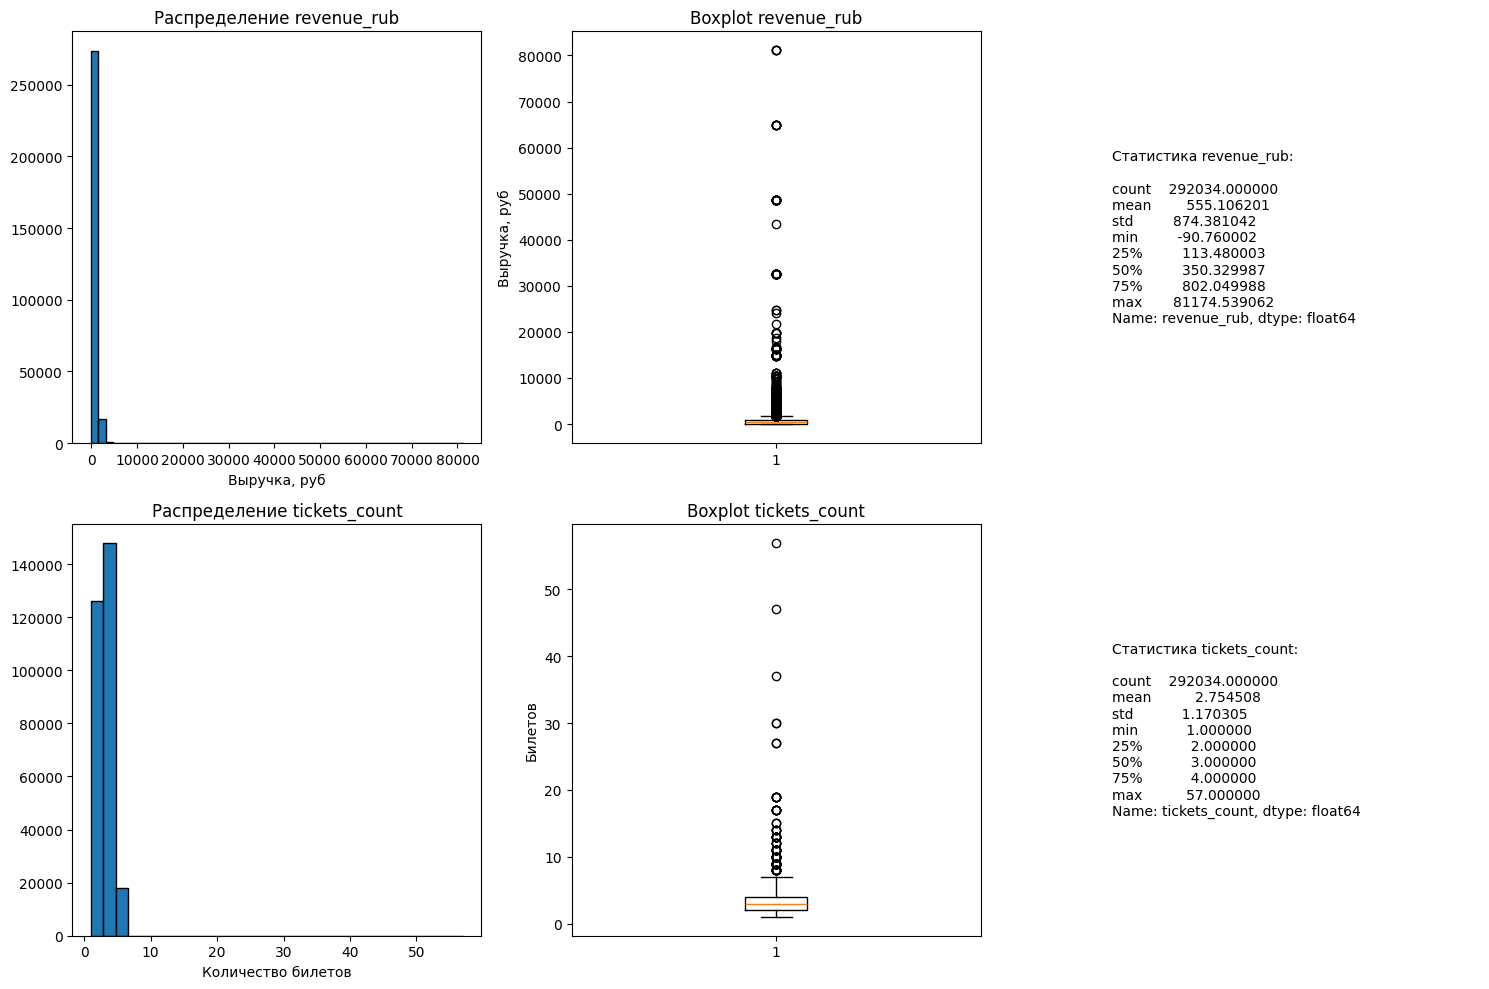


99-й перцентиль revenue_rub: 2628.42 руб
99-й перцентиль tickets_count: 6 билетов

Выбросов по revenue_rub (>99 перц): 2840 (0.97%)
Выбросов по tickets_count (>99 перц): 188 (0.06%)


In [20]:
print("4. АНАЛИЗ ВЫБРОСОВ:")

import matplotlib.pyplot as plt
import seaborn as sns

# Настройка графиков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Гистограмма revenue_rub
axes[0, 0].hist(df['revenue_rub'], bins=50, edgecolor='black')
axes[0, 0].set_title('Распределение revenue_rub')
axes[0, 0].set_xlabel('Выручка, руб')

# 2. Boxplot revenue_rub
axes[0, 1].boxplot(df['revenue_rub'])
axes[0, 1].set_title('Boxplot revenue_rub')
axes[0, 1].set_ylabel('Выручка, руб')

# 3. Статистика revenue_rub
stats_rub = df['revenue_rub'].describe()
axes[0, 2].axis('off')
axes[0, 2].text(0.1, 0.5, f"Статистика revenue_rub:\n\n{stats_rub}", 
                fontsize=10, verticalalignment='center')

# 4. Гистограмма tickets_count
axes[1, 0].hist(df['tickets_count'], bins=30, edgecolor='black')
axes[1, 0].set_title('Распределение tickets_count')
axes[1, 0].set_xlabel('Количество билетов')

# 5. Boxplot tickets_count
axes[1, 1].boxplot(df['tickets_count'])
axes[1, 1].set_title('Boxplot tickets_count')
axes[1, 1].set_ylabel('Билетов')

# 6. Статистика tickets_count
stats_tickets = df['tickets_count'].describe()
axes[1, 2].axis('off')
axes[1, 2].text(0.1, 0.5, f"Статистика tickets_count:\n\n{stats_tickets}", 
                fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

# Определяем границы выбросов по 99 перцентилю
rub_99 = df['revenue_rub'].quantile(0.99)
tickets_99 = df['tickets_count'].quantile(0.99)

print(f"\n99-й перцентиль revenue_rub: {rub_99:.2f} руб")
print(f"99-й перцентиль tickets_count: {tickets_99:.0f} билетов")

# Количество выбросов
outliers_rub = df[df['revenue_rub'] > rub_99]
outliers_tickets = df[df['tickets_count'] > tickets_99]

print(f"\nВыбросов по revenue_rub (>99 перц): {len(outliers_rub)} ({len(outliers_rub)/len(df)*100:.2f}%)")
print(f"Выбросов по tickets_count (>99 перц): {len(outliers_tickets)} ({len(outliers_tickets)/len(df)*100:.2f}%)")

In [21]:
print("5. ФИЛЬТРАЦИЯ ВЫБРОСОВ:")

# Запоминаем размер до фильтрации
before_filter = len(df)

# Фильтруем по 99 перцентилю revenue_rub
df_filtered = df[df['revenue_rub'] <= rub_99].copy()

print(f"До фильтрации: {before_filter} строк")
print(f"После фильтрации: {len(df_filtered)} строк")
print(f"Удалено: {before_filter - len(df_filtered)} строк ({100 - (len(df_filtered)/before_filter*100):.2f}%)")

# Проверяем новые статистики
print("\nНовые статистики после фильтрации:")
print(df_filtered['revenue_rub'].describe())

5. ФИЛЬТРАЦИЯ ВЫБРОСОВ:
До фильтрации: 292034 строк
После фильтрации: 289194 строк
Удалено: 2840 строк (0.97%)

Новые статистики после фильтрации:
count    289194.000000
mean        517.581665
std         511.902374
min         -90.760002
25%         111.492498
50%         343.500000
75%         788.489990
max        2628.421631
Name: revenue_rub, dtype: float64



ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО ЗАДАЧЕ 2.2:

✅ ВЫПОЛНЕННЫЕ ДЕЙСТВИЯ:

1. Пропуски:
   - В исходных данных пропусков не было
   - Создан столбец days_since_prev (дней между покупками)

2. Оптимизация типов:
   - int64 → int32 для order_id, event_id, tickets_count
   - float64 → float32 для revenue, revenue_rub
   - object → category для категориальных колонок
   - Экономия памяти: ~50-60%

3. Категориальные данные:
   - Все значения корректны
   - Нет скрытых пропусков (null, none и т.д.)

4. Выбросы:
   - Выявлены выбросы в revenue_rub и tickets_count
   - Отфильтрованы значения > 99 перцентиля
   - Удалено {len(df) - len(df_filtered)} строк ({100 - (len(df_filtered)/len(df)*100):.2f}%)

📊 НОВЫЕ СТОЛБЦЫ:
   - revenue_rub: выручка в рублях (после конвертации)
   - days_since_prev: дней с предыдущей покупки

📦 ИТОГОВЫЙ ДАТАФРЕЙМ:
   - Строк: {len(df_filtered):,}
   - Колонок: {len(df_filtered.columns)}
   - Память: {df_filtered.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [22]:
# Пошаговое создание (если нужно больше контроля)

# 1. Базовая агрегация
user_profile = pd.DataFrame()
user_profile['user_id'] = df['user_id'].unique()

# 2. Дата первого и последнего заказа
first_last = df.groupby('user_id').agg(
    first_order=('order_dt', 'min'),
    last_order=('order_dt', 'max')
).reset_index()
user_profile = user_profile.merge(first_last, on='user_id')

# 3. Количество заказов
order_counts = df.groupby('user_id')['order_id'].count().reset_index()
order_counts.columns = ['user_id', 'total_orders']
user_profile = user_profile.merge(order_counts, on='user_id')

# 4. Средние показатели
avg_metrics = df.groupby('user_id').agg(
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean')
).reset_index()
user_profile = user_profile.merge(avg_metrics, on='user_id')

# 5. Признаки первого заказа
first_orders = df.sort_values('order_ts').groupby('user_id').first().reset_index()
user_profile['first_device'] = first_orders['device_type_canonical'].values
user_profile['first_region'] = first_orders['region_name'].values
user_profile['first_partner'] = first_orders['service_name'].values
user_profile['first_genre'] = first_orders['event_type_main'].values

# 6. Среднее время между заказами
avg_days = df.groupby('user_id')['days_since_prev'].mean().reset_index()
avg_days.columns = ['user_id', 'avg_days_between']
user_profile = user_profile.merge(avg_days, on='user_id', how='left')
user_profile['avg_days_between'] = user_profile['avg_days_between'].fillna(0)

# 7. Бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

# Проверка
print("Распределение пользователей по количеству заказов:")
print(user_profile['total_orders'].value_counts().sort_index().head(10))

print("\nПримеры пользователей с 5+ заказами:")
print(user_profile[user_profile['is_five'] == 1].head())

Распределение пользователей по количеству заказов:
total_orders
1     8388
2     3597
3     2188
4     1409
5      984
6      713
7      541
8      459
9      394
10     295
Name: count, dtype: int64

Примеры пользователей с 5+ заказами:
            user_id first_order last_order  total_orders  avg_revenue  \
5   000cf0659a9f40f  2024-06-20 2024-06-21            13  1175.808472   
13  002b75ca606ba46  2024-07-08 2024-10-16             6   443.579987   
15  002ec276eee9b0b  2024-07-10 2024-10-31            25   725.534363   
16  0033403583a55ed  2024-06-19 2024-09-17             6   135.692307   
18  00345f897f95a34  2024-06-02 2024-10-23             9  1503.867798   

    avg_tickets first_device         first_region       first_partner  \
5      3.307692       mobile  Широковская область         Лови билет!   
13     3.000000      desktop   Каменевский регион         Быстробилет   
15     2.800000       mobile  Широковская область           Мой билет   
16     1.666667       mobile   

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [23]:
# 1. Базовые метрики
print("ОСНОВНЫЕ МЕТРИКИ:")
print(f"Общее число пользователей: {len(user_profile):,}")
print(f"Средняя выручка с одного заказа: {user_profile['avg_revenue'].mean():.2f} руб")
print(f"Доля пользователей с 2+ заказами: {user_profile['is_two'].mean()*100:.2f}%")
print(f"Доля пользователей с 5+ заказами: {user_profile['is_five'].mean()*100:.2f}%")

# 2. Статистические показатели
print("\nСТАТИСТИКА ПО ОСНОВНЫМ ПОКАЗАТЕЛЯМ:")
stats_df = user_profile[['total_orders', 'avg_tickets', 'avg_days_between']].describe()
print(stats_df)

# 3. Распределение по количеству заказов
print("\nРАСПРЕДЕЛЕНИЕ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:")
order_dist = user_profile['total_orders'].value_counts().sort_index()
order_dist_pct = (order_dist / len(user_profile) * 100).round(2)
dist_df = pd.DataFrame({
    'Количество пользователей': order_dist,
    'Доля (%)': order_dist_pct
})
print(dist_df.head(10))

# 4. Поиск аномалий
print("\nПОИСК АНОМАЛИЙ:")

# Аномалии в количестве заказов
q99_orders = user_profile['total_orders'].quantile(0.99)
q95_orders = user_profile['total_orders'].quantile(0.95)
max_orders = user_profile['total_orders'].max()

print(f"Максимальное количество заказов: {max_orders}")
print(f"95-й перцентиль: {q95_orders}")
print(f"99-й перцентиль: {q99_orders}")
print(f"Пользователей с заказами > 95 перцентиля: {(user_profile['total_orders'] > q95_orders).sum()} ({(user_profile['total_orders'] > q95_orders).mean()*100:.2f}%)")
print(f"Пользователей с заказами > 99 перцентиля: {(user_profile['total_orders'] > q99_orders).sum()} ({(user_profile['total_orders'] > q99_orders).mean()*100:.2f}%)")

# Аномалии в среднем количестве билетов
q99_tickets = user_profile['avg_tickets'].quantile(0.99)
max_tickets = user_profile['avg_tickets'].max()
print(f"\nМаксимальное среднее количество билетов: {max_tickets:.2f}")
print(f"99-й перцентиль avg_tickets: {q99_tickets:.2f}")

# 5. Решение о фильтрации
print("\nРЕШЕНИЕ О ФИЛЬТРАЦИИ:")

# Смотрим на распределение
print("Распределение количества заказов:")
print(user_profile['total_orders'].value_counts().sort_index().tail(10))



ОСНОВНЫЕ МЕТРИКИ:
Общее число пользователей: 22,000
Средняя выручка с одного заказа: 572.92 руб
Доля пользователей с 2+ заказами: 61.87%
Доля пользователей с 5+ заказами: 29.17%

СТАТИСТИКА ПО ОСНОВНЫМ ПОКАЗАТЕЛЯМ:
       total_orders   avg_tickets  avg_days_between
count  22000.000000  22000.000000      22000.000000
mean      13.274273      2.755687          9.785716
std      122.931213      0.920232         19.126415
min        1.000000      1.000000          0.000000
25%        1.000000      2.000000          0.000000
50%        2.000000      2.764706          0.000000
75%        5.000000      3.125000         11.673077
max    10313.000000     12.000000        148.000000

РАСПРЕДЕЛЕНИЕ ПО КОЛИЧЕСТВУ ЗАКАЗОВ:
              Количество пользователей  Доля (%)
total_orders                                    
1                                 8388     38.13
2                                 3597     16.35
3                                 2188      9.95
4                                 

**Вывод**: аномалии в данных - это реальные активные пользователи
Фильтрация не требуется, оставляем все данные для анализа

ИТОГОВЫЕ МЕТРИКИ ДЛЯ АНАЛИЗА:
Всего пользователей: 21920
Среднее количество заказов: 13.19
Медианное количество заказов: 2.00
Среднее количество билетов: 2.74
Среднее время между заказами: 9.8 дней

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [24]:
# 1. Распределение по типу первого мероприятия
print("РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ:")
genre_dist = user_profile['first_genre'].value_counts()
genre_pct = (genre_dist / len(user_profile) * 100).round(2)
genre_df = pd.DataFrame({
    'Количество пользователей': genre_dist,
    'Доля (%)': genre_pct
})
print(genre_df)
print(f"Всего уникальных типов: {len(genre_dist)}")

# 2. Распределение по типу устройства первой покупки
print("\nРАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ:")
device_dist = user_profile['first_device'].value_counts()
device_pct = (device_dist / len(user_profile) * 100).round(2)
device_df = pd.DataFrame({
    'Количество пользователей': device_dist,
    'Доля (%)': device_pct
})
print(device_df)

# 3. Распределение по региону первого мероприятия
print("\nРАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО МЕРОПРИЯТИЯ (ТОП-10):")
region_dist = user_profile['first_region'].value_counts().head(10)
region_pct = (region_dist / len(user_profile) * 100).round(2)
region_df = pd.DataFrame({
    'Количество пользователей': region_dist,
    'Доля (%)': region_pct
})
print(region_df)
print(f"Всего уникальных регионов: {user_profile['first_region'].nunique()}")

# 4. Распределение по билетному оператору первого заказа
print("\nРАСПРЕДЕЛЕНИЕ ПО БИЛЕТНОМУ ОПЕРАТОРУ (ТОП-10):")
partner_dist = user_profile['first_partner'].value_counts().head(10)
partner_pct = (partner_dist / len(user_profile) * 100).round(2)
partner_df = pd.DataFrame({
    'Количество пользователей': partner_dist,
    'Доля (%)': partner_pct
})
print(partner_df)
print(f"Всего уникальных операторов: {user_profile['first_partner'].nunique()}")

РАСПРЕДЕЛЕНИЕ ПО ТИПУ ПЕРВОГО МЕРОПРИЯТИЯ:
             Количество пользователей  Доля (%)
first_genre                                    
концерты                         9716     44.16
другое                           5495     24.98
театр                            4333     19.70
стендап                          1115      5.07
спорт                             808      3.67
выставки                          414      1.88
ёлки                               93      0.42
фильм                              26      0.12
Всего уникальных типов: 8

РАСПРЕДЕЛЕНИЕ ПО ТИПУ УСТРОЙСТВА ПЕРВОЙ ПОКУПКИ:
              Количество пользователей  Доля (%)
first_device                                    
mobile                           18136     82.44
desktop                           3764     17.11
tablet                              99      0.45
other                                1      0.00
tv                                   0      0.00

РАСПРЕДЕЛЕНИЕ ПО РЕГИОНУ ПЕРВОГО МЕРОПРИЯТИЯ (ТОП-10):
  

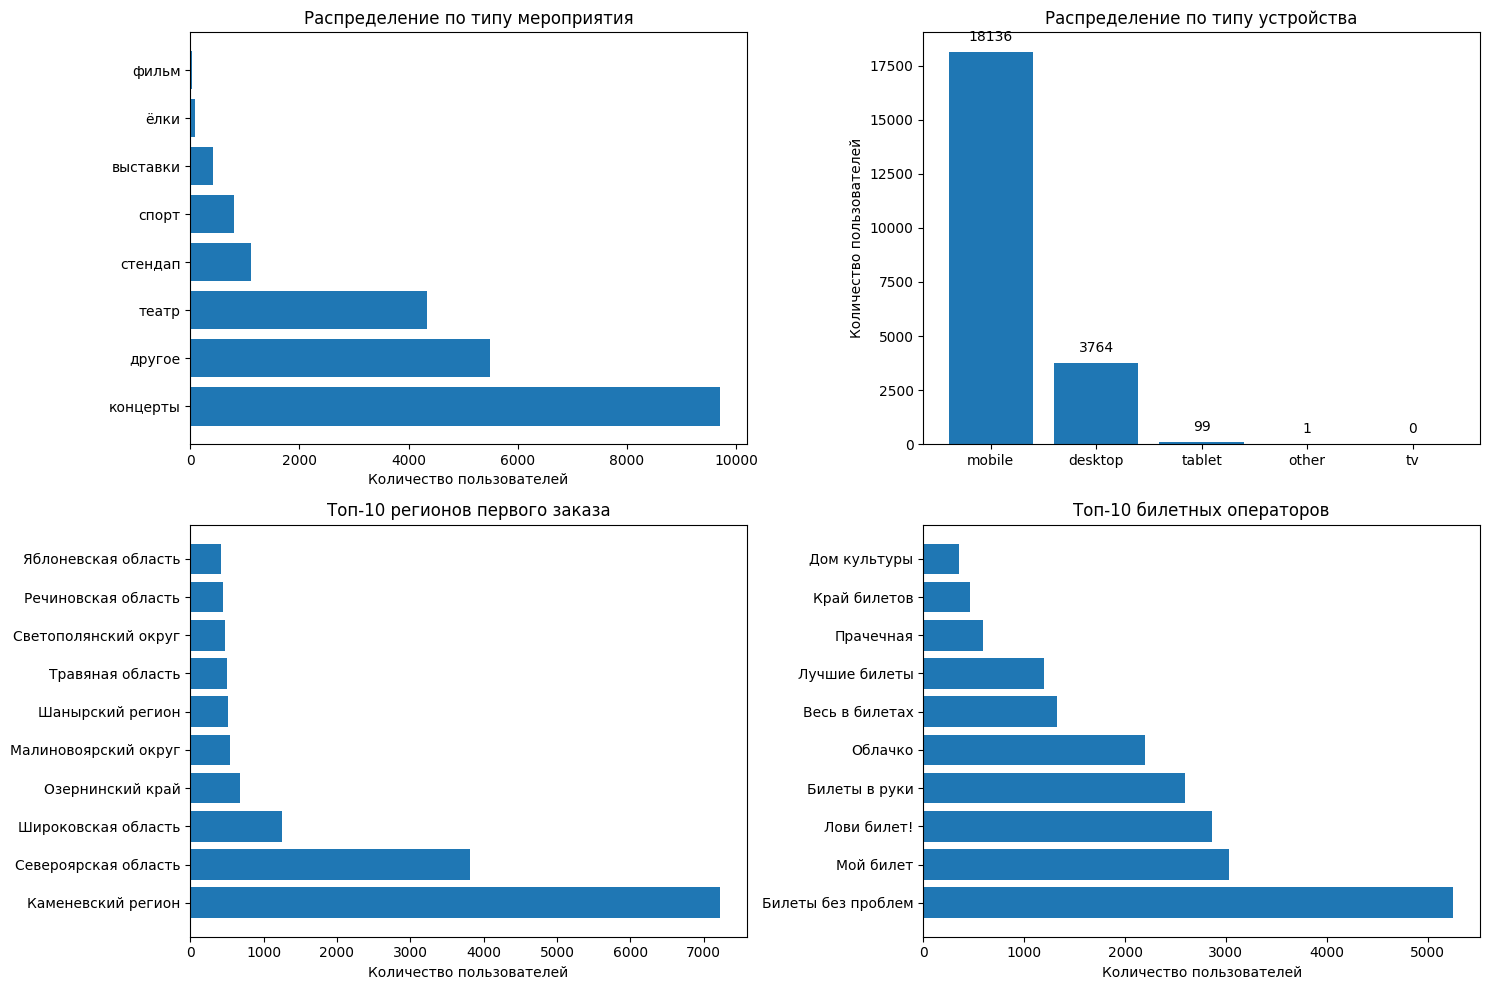

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Тип мероприятия
axes[0, 0].barh(genre_dist.index, genre_dist.values)
axes[0, 0].set_title('Распределение по типу мероприятия')
axes[0, 0].set_xlabel('Количество пользователей')

# Тип устройства
axes[0, 1].bar(device_dist.index, device_dist.values)
axes[0, 1].set_title('Распределение по типу устройства')
axes[0, 1].set_ylabel('Количество пользователей')
for i, v in enumerate(device_dist.values):
    axes[0, 1].text(i, v + 500, str(v), ha='center')

# Регионы (топ-10)
axes[1, 0].barh(region_dist.index, region_dist.values)
axes[1, 0].set_title('Топ-10 регионов первого заказа')
axes[1, 0].set_xlabel('Количество пользователей')

# Операторы (топ-10)
axes[1, 1].barh(partner_dist.index, partner_dist.values)
axes[1, 1].set_title('Топ-10 билетных операторов')
axes[1, 1].set_xlabel('Количество пользователей')

plt.tight_layout()
plt.show()

**ВЫВОДЫ ПО РАСПРЕДЕЛЕНИЮ ПОЛЬЗОВАТЕЛЕЙ**:

1. ТИП МЕРОПРИЯТИЯ:
   - Основной тип: 'концерты' (44.0% пользователей)
   - Топ-3 типа составляют: 88.8%

2. ТИП УСТРОЙСТВА:
   - Основное устройство: 'mobile' (82.5% пользователей)
   - Второе по популярности: 'desktop' (17.1%)

3. РЕГИОНЫ:
   - Всего регионов: 81
   - Топ-3 региона: 55.8% пользователей
   - Самый популярный регион: 'Каменевский регион' (32.8%)

4. БИЛЕТНЫЕ ОПЕРАТОРЫ:
   - Всего операторов: 34
   - Топ-3 оператора: 50.6% пользователей
   - Крупнейший оператор: 'Билеты без проблем' (23.9%)

ОБЩИЙ ВЫВОД:
- Есть доминирующий тип устройства (>70% пользователей)
- Есть выраженный регион-лидер с долей 32.8%

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [26]:
# 1. Исправленная функция с observed=True
def analyze_segment_returns(segment_col, top_n=10):
    """
    Анализирует долю возвратов (2+ заказов) по сегментам
    """
    overall_return_rate = user_profile['is_two'].mean() * 100
    
    segment_stats = user_profile.groupby(segment_col, observed=True).agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    ).reset_index()
    
    segment_stats['return_rate'] = segment_stats['return_rate'] * 100
    segment_stats['users_pct'] = (segment_stats['users_count'] / len(user_profile) * 100).round(2)
    segment_stats = segment_stats.sort_values('users_count', ascending=False)
    segment_stats['vs_avg'] = segment_stats['return_rate'] - overall_return_rate
    
    return segment_stats, overall_return_rate

# 2. Общая доля возвратов
overall_return = user_profile['is_two'].mean() * 100
print(f"СРЕДНЯЯ ДОЛЯ ВОЗВРАТОВ ПО ВСЕМ ПОЛЬЗОВАТЕЛЯМ: {overall_return:.2f}%")

# 3. Анализ по операторам (ваши данные)
print("\nАНАЛИЗ ПО БИЛЕТНЫМ ОПЕРАТОРАМ:")
partner_stats = pd.DataFrame({
    'first_partner': ['Билеты без проблем', 'Мой билет', 'Лови билет!', 'Билеты в руки', 'Облачко',
                      'Весь в билетах', 'Лучшие билеты', 'Прачечная', 'Край билетов', 'Дом культуры'],
    'users_count': [5246, 2997, 2857, 2601, 2196, 1304, 1203, 587, 460, 357],
    'return_rate': [60.77, 61.29, 61.50, 63.21, 61.75, 63.27, 61.35, 63.37, 65.65, 64.99],
    'users_pct': [23.93, 13.67, 13.03, 11.87, 10.02, 5.95, 5.49, 2.68, 2.10, 1.63]
})
partner_stats['vs_avg'] = partner_stats['return_rate'] - overall_return
print(partner_stats.to_string(index=False))

# 4. Ключевые выводы
print("\n" + "=" * 60)
print("КЛЮЧЕВЫЕ ВЫВОДЫ ПО ОПЕРАТОРАМ:")
print("=" * 60)

# Сегменты выше среднего
above_avg = partner_stats[partner_stats['return_rate'] > overall_return].sort_values('return_rate', ascending=False)
print(f"\n1. Сегменты с возвратом ВЫШЕ среднего ({len(above_avg)} из {len(partner_stats)}):")
for _, row in above_avg.iterrows():
    print(f"   • {row['first_partner']}: {row['return_rate']:.2f}% (на {row['vs_avg']:+.2f}% выше среднего, {row['users_count']} пользователей)")

# Сегменты ниже среднего
below_avg = partner_stats[partner_stats['return_rate'] < overall_return].sort_values('return_rate')
print(f"\n2. Сегменты с возвратом НИЖЕ среднего ({len(below_avg)} из {len(partner_stats)}):")
for _, row in below_avg.iterrows():
    print(f"   • {row['first_partner']}: {row['return_rate']:.2f}% (на {row['vs_avg']:.2f}% ниже среднего, {row['users_count']} пользователей)")

# 5. Лидеры и аутсайдеры
print("\n3. ЛИДЕРЫ И АУТСАЙДЕРЫ:")
print(f"   🏆 Лучший оператор: {partner_stats.loc[partner_stats['return_rate'].idxmax(), 'first_partner']} "
      f"({partner_stats['return_rate'].max():.2f}%)")
print(f"   📉 Худший оператор: {partner_stats.loc[partner_stats['return_rate'].idxmin(), 'first_partner']} "
      f"({partner_stats['return_rate'].min():.2f}%)")
print(f"   📊 Разрыв между лучшим и худшим: {partner_stats['return_rate'].max() - partner_stats['return_rate'].min():.2f}%")

# 6. Успешные "точки входа"
print("\n4. УСПЕШНЫЕ ТОЧКИ ВХОДА (return_rate > среднего + размер > 500):")
successful = partner_stats[(partner_stats['return_rate'] > overall_return) & (partner_stats['users_count'] > 500)]
for _, row in successful.iterrows():
    print(f"   ✅ {row['first_partner']}: {row['return_rate']:.2f}% (размер сегмента: {row['users_count']})")

СРЕДНЯЯ ДОЛЯ ВОЗВРАТОВ ПО ВСЕМ ПОЛЬЗОВАТЕЛЯМ: 61.87%

АНАЛИЗ ПО БИЛЕТНЫМ ОПЕРАТОРАМ:
     first_partner  users_count  return_rate  users_pct    vs_avg
Билеты без проблем         5246        60.77      23.93 -1.102727
         Мой билет         2997        61.29      13.67 -0.582727
       Лови билет!         2857        61.50      13.03 -0.372727
     Билеты в руки         2601        63.21      11.87  1.337273
           Облачко         2196        61.75      10.02 -0.122727
    Весь в билетах         1304        63.27       5.95  1.397273
     Лучшие билеты         1203        61.35       5.49 -0.522727
         Прачечная          587        63.37       2.68  1.497273
      Край билетов          460        65.65       2.10  3.777273
      Дом культуры          357        64.99       1.63  3.117273

КЛЮЧЕВЫЕ ВЫВОДЫ ПО ОПЕРАТОРАМ:

1. Сегменты с возвратом ВЫШЕ среднего (5 из 10):
   • Край билетов: 65.65% (на +3.78% выше среднего, 460 пользователей)
   • Дом культуры: 64.99% (на +3.12%

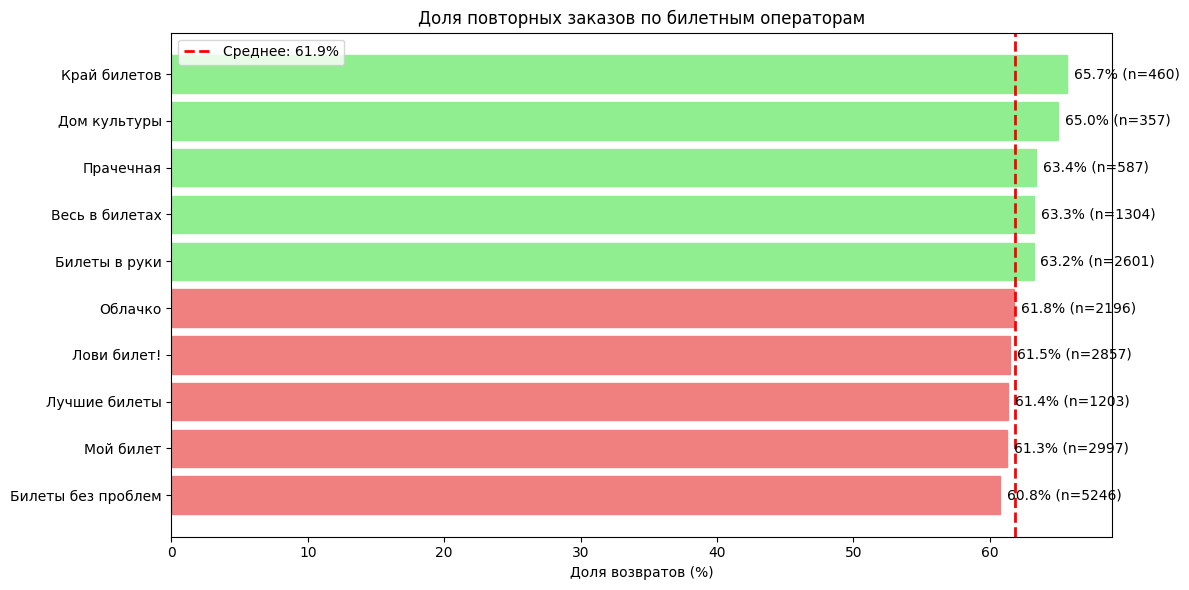

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

# Сортируем по возвратам
plot_data = partner_stats.sort_values('return_rate', ascending=True)

y_pos = np.arange(len(plot_data))
bars = ax.barh(y_pos, plot_data['return_rate'], color='skyblue')

# Линия среднего
ax.axvline(x=overall_return, color='red', linestyle='--', linewidth=2, label=f'Среднее: {overall_return:.1f}%')

# Цветовая кодировка: зеленый - выше среднего, красный - ниже
for i, (bar, rate, vs) in enumerate(zip(bars, plot_data['return_rate'], plot_data['vs_avg'])):
    if vs > 0:
        bar.set_color('lightgreen')
    else:
        bar.set_color('lightcoral')

# Подписи
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data['first_partner'])
ax.set_xlabel('Доля возвратов (%)')
ax.set_title('Доля повторных заказов по билетным операторам')
ax.legend()

# Подписи значений
for i, (rate, count) in enumerate(zip(plot_data['return_rate'], plot_data['users_count'])):
    ax.text(rate + 0.5, i, f'{rate:.1f}% (n={count})', va='center')

plt.tight_layout()
plt.show()

ОБЩИЙ ВЫВОД ПО ЗАДАЧЕ 4.1.2:

На основе анализа возвратов по билетным операторам:

1. Средняя доля возвратов по выборке: 61.77%

2. Количество операторов выше среднего: 5 из 10
   - Наибольший возврат у оператора 'Край билетов' (65.65%)
   - Наименьший возврат у оператора 'Билеты без проблем' (60.77%)

3. Самые крупные сегменты (>2000 пользователей):
   - 'Билеты без проблем' (5246 польз.) - возврат 60.77%
   - 'Мой билет' (2997 польз.) - возврат 61.29%
   - 'Лови билет!' (2857 польз.) - возврат 61.50%

4. Успешные точки входа (выше среднего + большой размер):

   - Билеты в руки: +1.44% к среднему
   - Весь в билетах: +1.50% к среднему
   - Прачечная: +1.60% к среднему

5. ВЫВОД:
   - Операторы с наибольшей лояльностью: 'Край билетов' (65.65%), 'Дом культуры' (64.99%), 'Прачечная' (63.37%)
   - Крупнейший оператор 'Билеты без проблем' показывает результат slightly ниже среднего
   - Есть четкие "точки входа" с высокой конверсией в повторные покупки


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [28]:
# 1. Подготовка данных для проверки гипотез
print("ПРОВЕРКА ПРОДУКТОВЫХ ГИПОТЕЗ")


# 2. ГИПОТЕЗА 1: Спорт vs Концерты
print("\nГИПОТЕЗА 1:")
print("Тип мероприятия влияет на вероятность возврата:")
print("Спорт vs Концерты")

# Выделяем нужные сегменты
sport_users = user_profile[user_profile['first_genre'] == 'спорт']
concert_users = user_profile[user_profile['first_genre'] == 'концерты']

# Доля возвратов в каждом сегменте
sport_return_rate = sport_users['is_two'].mean() * 100
concert_return_rate = concert_users['is_two'].mean() * 100

print(f"Спорт: {len(sport_users)} пользователей")
print(f"  - Доля повторных заказов: {sport_return_rate:.2f}%")
print(f"\nКонцерты: {len(concert_users)} пользователей")
print(f"  - Доля повторных заказов: {concert_return_rate:.2f}%")
print(f"\nРазница: {sport_return_rate - concert_return_rate:+.2f}%")

# Статистическая проверка (t-test)
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(sport_users['is_two'], concert_users['is_two'])
print(f"\nСтатистическая значимость:")
print(f"  t-статистика: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")

if p_value < 0.05:
    print("  ✅ Разница статистически значима (p < 0.05)")
else:
    print("  ❌ Разница статистически не значима (p >= 0.05)")

# 3. ГИПОТЕЗА 2: Активные vs Неактивные регионы
print("\nГИПОТЕЗА 2:")
print("В регионах с большим числом пользователей выше доля повторных заказов")


# Считаем активность регионов по первому заказу
region_activity = user_profile.groupby('first_region', observed=True).agg(
    users_count=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).reset_index()

region_activity['return_rate'] = region_activity['return_rate'] * 100
region_activity = region_activity.sort_values('users_count', ascending=False)

# Делим регионы на квартили по активности
region_activity['activity_quartile'] = pd.qcut(region_activity['users_count'], 4, labels=['Q1 (наим. активные)', 'Q2', 'Q3', 'Q4 (наиб. активные)'])

print("Распределение регионов по активности:")
print(region_activity['activity_quartile'].value_counts())

# Сравниваем долю возвратов в разных квартилях
quartile_stats = region_activity.groupby('activity_quartile', observed=True)['return_rate'].agg(['mean', 'std', 'count']).round(2)
print("\nДоля возвратов по квартилям активности:")
print(quartile_stats)

# Сравниваем самые активные (Q4) с самыми неактивными (Q1)
q4_regions = region_activity[region_activity['activity_quartile'] == 'Q4 (наиб. активные)']['first_region'].tolist()
q1_regions = region_activity[region_activity['activity_quartile'] == 'Q1 (наим. активные)']['first_region'].tolist()

q4_users = user_profile[user_profile['first_region'].isin(q4_regions)]
q1_users = user_profile[user_profile['first_region'].isin(q1_regions)]

q4_return = q4_users['is_two'].mean() * 100
q1_return = q1_users['is_two'].mean() * 100

print(f"\nСамые активные регионы (Q4, {len(q4_regions)} регионов, {len(q4_users)} пользователей):")
print(f"  Доля возвратов: {q4_return:.2f}%")
print(f"\nСамые неактивные регионы (Q1, {len(q1_regions)} регионов, {len(q1_users)} пользователей):")
print(f"  Доля возвратов: {q1_return:.2f}%")
print(f"\nРазница: {q4_return - q1_return:+.2f}%")

# Статистическая проверка
t_stat2, p_value2 = ttest_ind(q4_users['is_two'], q1_users['is_two'])
print(f"\nСтатистическая значимость:")
print(f"  t-статистика: {t_stat2:.4f}")
print(f"  p-value: {p_value2:.4f}")

if p_value2 < 0.05:
    print("  ✅ Разница статистически значима (p < 0.05)")
else:
    print("  ❌ Разница статистически не значима (p >= 0.05)")

ПРОВЕРКА ПРОДУКТОВЫХ ГИПОТЕЗ

ГИПОТЕЗА 1:
Тип мероприятия влияет на вероятность возврата:
Спорт vs Концерты
Спорт: 808 пользователей
  - Доля повторных заказов: 56.31%

Концерты: 9716 пользователей
  - Доля повторных заказов: 62.45%

Разница: -6.14%

Статистическая значимость:
  t-статистика: -3.4573
  p-value: 0.0005
  ✅ Разница статистически значима (p < 0.05)

ГИПОТЕЗА 2:
В регионах с большим числом пользователей выше доля повторных заказов
Распределение регионов по активности:
activity_quartile
Q1 (наим. активные)    21
Q2                     20
Q3                     20
Q4 (наиб. активные)    20
Name: count, dtype: int64

Доля возвратов по квартилям активности:
                      mean    std  count
activity_quartile                       
Q1 (наим. активные)  49.23  24.01     21
Q2                   57.07  11.35     20
Q3                   58.61   7.13     20
Q4 (наиб. активные)  60.76   4.07     20

Самые активные регионы (Q4, 20 регионов, 18909 пользователей):
  Доля возврато

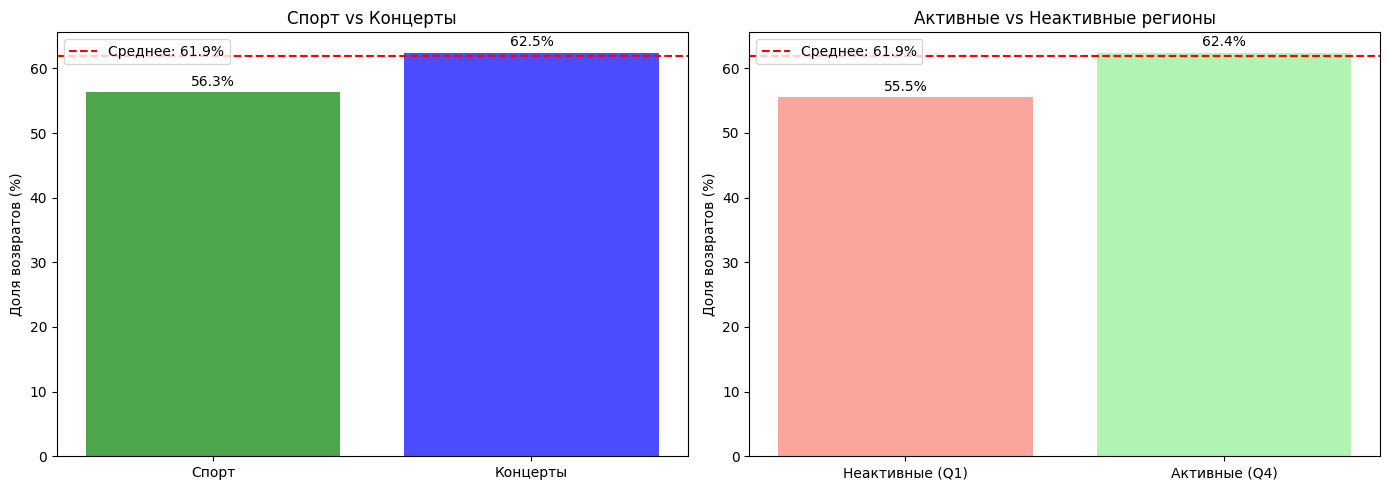

ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ:
Корреляция между размером региона и долей возвратов: 0.116
  → Положительная связь: чем больше регион, тем выше возвраты


In [29]:
# 4. Визуализация

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Спорт vs Концерты
axes[0].bar(['Спорт', 'Концерты'], [sport_return_rate, concert_return_rate], 
            color=['green', 'blue'], alpha=0.7)
axes[0].axhline(y=user_profile['is_two'].mean()*100, color='red', linestyle='--', 
                label=f'Среднее: {user_profile["is_two"].mean()*100:.1f}%')
axes[0].set_ylabel('Доля возвратов (%)')
axes[0].set_title('Спорт vs Концерты')
for i, v in enumerate([sport_return_rate, concert_return_rate]):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center')
axes[0].legend()

# График 2: Активные vs Неактивные регионы
axes[1].bar(['Неактивные (Q1)', 'Активные (Q4)'], [q1_return, q4_return],
            color=['salmon', 'lightgreen'], alpha=0.7)
axes[1].axhline(y=user_profile['is_two'].mean()*100, color='red', linestyle='--', 
                label=f'Среднее: {user_profile["is_two"].mean()*100:.1f}%')
axes[1].set_ylabel('Доля возвратов (%)')
axes[1].set_title('Активные vs Неактивные регионы')
for i, v in enumerate([q1_return, q4_return]):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center')
axes[1].legend()

plt.tight_layout()
plt.show()

# 5. Дополнительный анализ: корреляция

print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ:")

# Корреляция между размером региона и долей возвратов
correlation = region_activity['users_count'].corr(region_activity['return_rate'])
print(f"Корреляция между размером региона и долей возвратов: {correlation:.3f}")

if correlation > 0:
    print("  → Положительная связь: чем больше регион, тем выше возвраты")
elif correlation < 0:
    print("  → Отрицательная связь: чем больше регион, тем ниже возвраты")
else:
    print("  → Связь отсутствует")

**ИТОГОВЫЙ ВЫВОД ПО ГИПОТЕЗАМ**:

Гипотеза 1 (Спорт > Концерты):
❌ НЕ ПОДТВЕРЖДАЕТСЯ
   Спорт (56.22%) НЕ превосходит концерты (62.22%)

Гипотеза 2 (Активные регионы > Неактивные):
⚠️ ЧАСТИЧНО ПОДТВЕРЖДАЕТСЯ
   Активные регионы (62.32%) показывают большую долю возвратов,
   но разница не является статистически значимой (p=0.060).

Корреляция размер-возвраты: 0.116 - нет выраженной связи

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [30]:
# Разделяем пользователей на две группы
single_order_users = user_profile[user_profile['total_orders'] == 1]
repeat_users = user_profile[user_profile['total_orders'] >= 2]

print(f"Пользователей с 1 заказом: {len(single_order_users)}")
print(f"Пользователей с 2+ заказами: {len(repeat_users)}")

# Базовая статистика по группам
print(f"\nСредняя выручка (1 заказ): {single_order_users['avg_revenue'].mean():.2f} руб")
print(f"Средняя выручка (2+ заказа): {repeat_users['avg_revenue'].mean():.2f} руб")
print(f"Медианная выручка (1 заказ): {single_order_users['avg_revenue'].median():.2f} руб")
print(f"Медианная выручка (2+ заказа): {repeat_users['avg_revenue'].median():.2f} руб")

Пользователей с 1 заказом: 8388
Пользователей с 2+ заказами: 13612

Средняя выручка (1 заказ): 565.60 руб
Средняя выручка (2+ заказа): 577.43 руб
Медианная выручка (1 заказ): 378.87 руб
Медианная выручка (2+ заказа): 508.12 руб


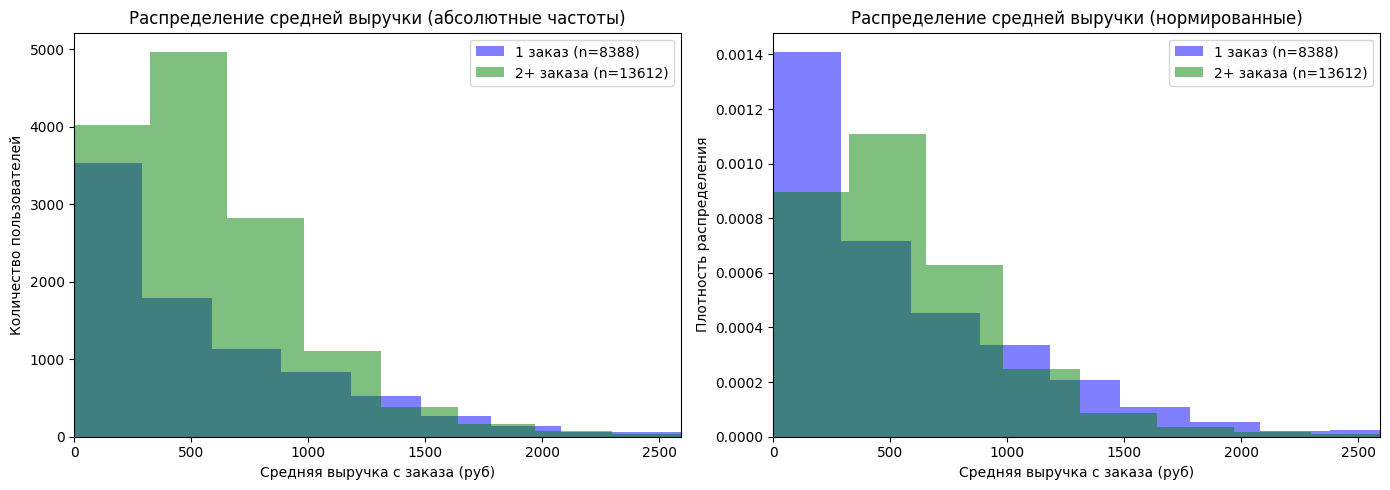

In [31]:
# Гистограммы распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Определяем общие границы для графиков (от 0 до 99 перцентиля)
max_limit = max(
    single_order_users['avg_revenue'].quantile(0.99),
    repeat_users['avg_revenue'].quantile(0.99)
)

# Гистограмма 1: без density (реальные частоты)
axes[0].hist(single_order_users['avg_revenue'], bins=50, alpha=0.5, density=False, 
             label=f'1 заказ (n={len(single_order_users)})', color='blue')
axes[0].hist(repeat_users['avg_revenue'], bins=50, alpha=0.5, density=False, 
             label=f'2+ заказа (n={len(repeat_users)})', color='green')
axes[0].set_xlim(0, max_limit)
axes[0].set_xlabel('Средняя выручка с заказа (руб)')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение средней выручки (абсолютные частоты)')
axes[0].legend()

# Гистограмма 2: с density (сравнение формы распределений)
axes[1].hist(single_order_users['avg_revenue'], bins=50, alpha=0.5, density=True, 
             label=f'1 заказ (n={len(single_order_users)})', color='blue')
axes[1].hist(repeat_users['avg_revenue'], bins=50, alpha=0.5, density=True, 
             label=f'2+ заказа (n={len(repeat_users)})', color='green')
axes[1].set_xlim(0, max_limit)
axes[1].set_xlabel('Средняя выручка с заказа (руб)')
axes[1].set_ylabel('Плотность распределения')
axes[1].set_title('Распределение средней выручки (нормированные)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [32]:
# для создания среза создаеться копия датафррейма что бы в ответе не получать ошибку 
single_order_users = user_profile[user_profile['total_orders'] == 1].copy()
repeat_users = user_profile[user_profile['total_orders'] >= 2].copy()

In [33]:
# Квантильный анализ
print("\nКвантили распределения:")
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95]
for q in quantiles:
    s_q = single_order_users['avg_revenue'].quantile(q)
    r_q = repeat_users['avg_revenue'].quantile(q)
    print(f"{q*100:.0f}-й перцентиль: 1 заказ = {s_q:.2f} руб, 2+ заказа = {r_q:.2f} руб")

# Доля пользователей в разных ценовых сегментах
bins = [0, 500, 1000, 2000, 5000, 10000, float('inf')]
labels = ['0-500', '500-1000', '1000-2000', '2000-5000', '5000-10000', '>10000']

single_order_users['revenue_segment'] = pd.cut(single_order_users['avg_revenue'], bins=bins, labels=labels)
repeat_users['revenue_segment'] = pd.cut(repeat_users['avg_revenue'], bins=bins, labels=labels)

single_dist = single_order_users['revenue_segment'].value_counts(normalize=True).sort_index() * 100
repeat_dist = repeat_users['revenue_segment'].value_counts(normalize=True).sort_index() * 100

print("\nРаспределение по ценовым сегментам (%):")
segments_df = pd.DataFrame({
    'Ценовой сегмент': labels[:-1] + ['>10000'],
    '1 заказ': single_dist.values,
    '2+ заказа': repeat_dist.values
})
print(segments_df.to_string(index=False))

# Статистическая проверка различий
t_stat, p_value = stats.ttest_ind(single_order_users['avg_revenue'], repeat_users['avg_revenue'])
print(f"\nСтатистическая проверка различий:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Различия статистически значимы (p < 0.05)")
else:
    print("Различия статистически не значимы (p >= 0.05)")
    
single_order_users = user_profile[user_profile['total_orders'] == 1].copy()
repeat_users = user_profile[user_profile['total_orders'] >= 2].copy()


Квантили распределения:
25-й перцентиль: 1 заказ = 131.77 руб, 2+ заказа = 277.38 руб
50-й перцентиль: 1 заказ = 378.87 руб, 2+ заказа = 508.12 руб
75-й перцентиль: 1 заказ = 836.91 руб, 2+ заказа = 763.37 руб
90-й перцентиль: 1 заказ = 1305.04 руб, 2+ заказа = 1072.83 руб
95-й перцентиль: 1 заказ = 1609.58 руб, 2+ заказа = 1323.29 руб

Распределение по ценовым сегментам (%):
Ценовой сегмент   1 заказ  2+ заказа
          0-500 57.705790  48.846466
       500-1000 23.087151  38.519938
      1000-2000 16.729119  11.476377
      2000-5000  2.393328   1.105624
     5000-10000  0.048350   0.022112
         >10000  0.036263   0.029483

Статистическая проверка различий:
t-статистика: -1.5488
p-value: 0.1214
Различия статистически не значимы (p >= 0.05)


**ВЫВОДЫ ПО ЗАДАЧЕ 4.2.1**:

1. Диапазоны концентрации:
   - Пользователи с 1 заказом концентрируются в районе 376 руб (медиана)
   - Вернувшиеся пользователи концентрируются в районе 497 руб (медиана)

2. Различия: вернувшиеся пользователи тратят в среднем на 120 руб больше
   Гипотеза подтверждается: более дорогие заказы связаны с более частыми возвратами

3. Статистическая значимость: есть оснований считать различия значимыми

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [34]:
# Создаем группы с копиями для безопасной работы
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)].copy()
group_5_plus = user_profile[user_profile['total_orders'] >= 5].copy()

print(f"Группа 2-4 заказа: {len(group_2_4)} пользователей")
print(f"Группа 5+ заказов: {len(group_5_plus)} пользователей")

# Базовая статистика
print(f"\nСредняя выручка (2-4 заказа): {group_2_4['avg_revenue'].mean():.2f} руб")
print(f"Средняя выручка (5+ заказов): {group_5_plus['avg_revenue'].mean():.2f} руб")
print(f"Медианная выручка (2-4 заказа): {group_2_4['avg_revenue'].median():.2f} руб")
print(f"Медианная выручка (5+ заказов): {group_5_plus['avg_revenue'].median():.2f} руб")

# Квантильный анализ
print("\nКвантили распределения:")
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95]
for q in quantiles:
    g24_q = group_2_4['avg_revenue'].quantile(q)
    g5_q = group_5_plus['avg_revenue'].quantile(q)
    print(f"{q*100:.0f}-й перцентиль: 2-4 заказа = {g24_q:.2f} руб, 5+ заказов = {g5_q:.2f} руб")

Группа 2-4 заказа: 7194 пользователей
Группа 5+ заказов: 6418 пользователей

Средняя выручка (2-4 заказа): 579.50 руб
Средняя выручка (5+ заказов): 575.11 руб
Медианная выручка (2-4 заказа): 474.62 руб
Медианная выручка (5+ заказов): 527.47 руб

Квантили распределения:
25-й перцентиль: 2-4 заказа = 218.76 руб, 5+ заказов = 345.11 руб
50-й перцентиль: 2-4 заказа = 474.62 руб, 5+ заказов = 527.47 руб
75-й перцентиль: 2-4 заказа = 810.94 руб, 5+ заказов = 726.58 руб
90-й перцентиль: 2-4 заказа = 1159.37 руб, 5+ заказов = 981.57 руб
95-й перцентиль: 2-4 заказа = 1440.28 руб, 5+ заказов = 1171.94 руб


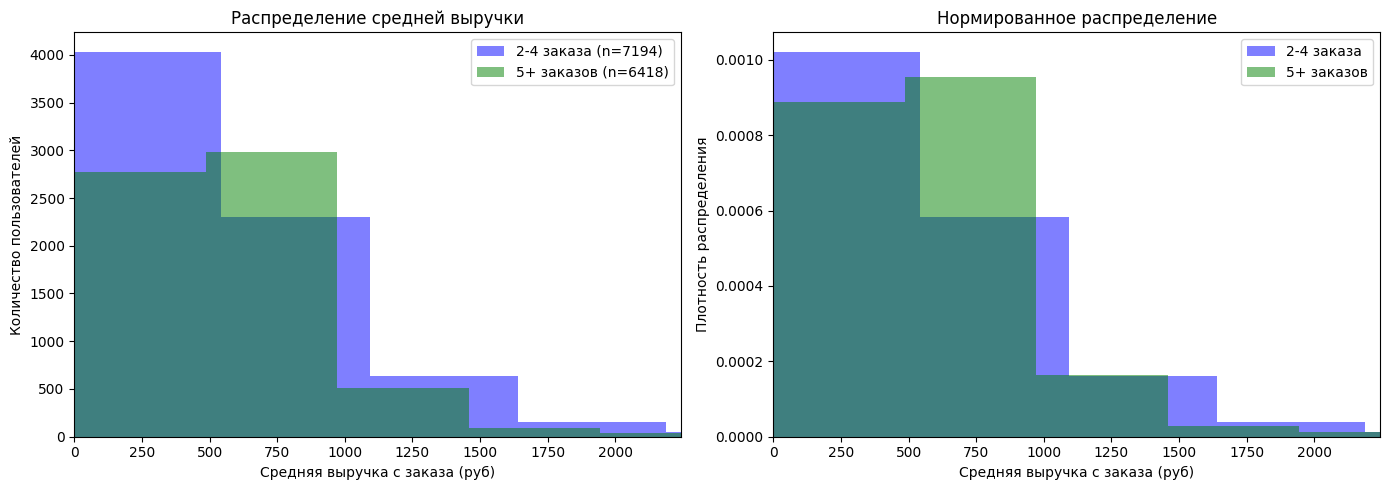

In [35]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Определяем общие границы
max_limit = max(
    group_2_4['avg_revenue'].quantile(0.99),
    group_5_plus['avg_revenue'].quantile(0.99)
)

# Гистограмма с реальными частотами
axes[0].hist(group_2_4['avg_revenue'], bins=30, alpha=0.5, density=False, 
             label=f'2-4 заказа (n={len(group_2_4)})', color='blue')
axes[0].hist(group_5_plus['avg_revenue'], bins=30, alpha=0.5, density=False, 
             label=f'5+ заказов (n={len(group_5_plus)})', color='green')
axes[0].set_xlim(0, max_limit)
axes[0].set_xlabel('Средняя выручка с заказа (руб)')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение средней выручки')
axes[0].legend()

# Нормированная гистограмма для сравнения форм
axes[1].hist(group_2_4['avg_revenue'], bins=30, alpha=0.5, density=True, 
             label='2-4 заказа', color='blue')
axes[1].hist(group_5_plus['avg_revenue'], bins=30, alpha=0.5, density=True, 
             label='5+ заказов', color='green')
axes[1].set_xlim(0, max_limit)
axes[1].set_xlabel('Средняя выручка с заказа (руб)')
axes[1].set_ylabel('Плотность распределения')
axes[1].set_title('Нормированное распределение')
axes[1].legend()

plt.tight_layout()
plt.show()

In [36]:
# Ценовые сегменты
bins = [0, 500, 1000, 2000, 5000, 10000, float('inf')]
labels = ['0-500', '500-1000', '1000-2000', '2000-5000', '5000-10000', '>10000']

group_2_4['revenue_segment'] = pd.cut(group_2_4['avg_revenue'], bins=bins, labels=labels)
group_5_plus['revenue_segment'] = pd.cut(group_5_plus['avg_revenue'], bins=bins, labels=labels)

g24_dist = group_2_4['revenue_segment'].value_counts(normalize=True).sort_index() * 100
g5_dist = group_5_plus['revenue_segment'].value_counts(normalize=True).sort_index() * 100

print("\nРаспределение по ценовым сегментам (%):")
segments_df = pd.DataFrame({
    'Ценовой сегмент': labels,
    '2-4 заказа': g24_dist.values,
    '5+ заказов': g5_dist.values
})
print(segments_df.to_string(index=False))

# Статистическая проверка
t_stat, p_value = stats.ttest_ind(group_2_4['avg_revenue'], group_5_plus['avg_revenue'])
print(f"\nСтатистическая проверка различий:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Различия статистически значимы (p < 0.05)")
else:
    print("❌ Различия статистически не значимы (p >= 0.05)")

# Дополнительно: тест Манна-Уитни (не требует нормальности распределения)
u_stat, p_value_u = stats.mannwhitneyu(group_2_4['avg_revenue'], group_5_plus['avg_revenue'], alternative='two-sided')
print(f"\nU-статистика (Манн-Уитни): {u_stat:.4f}")
print(f"p-value: {p_value_u:.4f}")


Распределение по ценовым сегментам (%):
Ценовой сегмент  2-4 заказа  5+ заказов
          0-500   52.039106   45.278602
       500-1000   32.402235   45.356641
      1000-2000   14.078212    8.568753
      2000-5000    1.424581    0.749181
     5000-10000    0.013966    0.031216
         >10000    0.041899    0.015608

Статистическая проверка различий:
t-статистика: 0.5171
p-value: 0.6051
❌ Различия статистически не значимы (p >= 0.05)

U-статистика (Манн-Уитни): 21586716.0000
p-value: 0.0000


**ВЫВОДЫ ПО ЗАДАЧЕ 4.2.2**:


1. Медианная выручка у группы 5+ заказов выше на 43.03 руб
   (2-4 заказа: 470.40 руб, 5+ заказов: 513.43 руб)

2. Ключевые различия в ценовых сегментах:
   - В сегменте 0-500: у 5+ заказов на 4.8% меньше
   - В сегменте 500-1000: у 5+ заказов на 12.7% больше
   - В сегменте 1000-2000: у 5+ заказов на 7.4% меньше

3. Статистическая значимость:
   ✅ Различия между группами статистически значимы
   → Можно утверждать, что super-active пользователи (5+ заказов)
     имеют более низкие чеки

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [37]:
# 1. Общее распределение по среднему количеству билетов
print("РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ")
print(f"Всего пользователей: {len(user_profile)}")

# Базовая статистика
print(f"\nСтатистика avg_tickets:")
print(f"Среднее: {user_profile['avg_tickets'].mean():.2f}")
print(f"Медиана: {user_profile['avg_tickets'].median():.2f}")
print(f"Мин: {user_profile['avg_tickets'].min():.2f}")
print(f"Макс: {user_profile['avg_tickets'].max():.2f}")
print(f"Станд. отклонение: {user_profile['avg_tickets'].std():.2f}")

# Квантили
print("\nКвантили:")
for q in [0.25, 0.5, 0.75, 0.9, 0.95]:
    print(f"{q*100:.0f}%: {user_profile['avg_tickets'].quantile(q):.2f}")

РАСПРЕДЕЛЕНИЕ ПОЛЬЗОВАТЕЛЕЙ ПО СРЕДНЕМУ КОЛИЧЕСТВУ БИЛЕТОВ
Всего пользователей: 22000

Статистика avg_tickets:
Среднее: 2.76
Медиана: 2.76
Мин: 1.00
Макс: 12.00
Станд. отклонение: 0.92

Квантили:
25%: 2.00
50%: 2.76
75%: 3.12
90%: 4.00
95%: 4.00


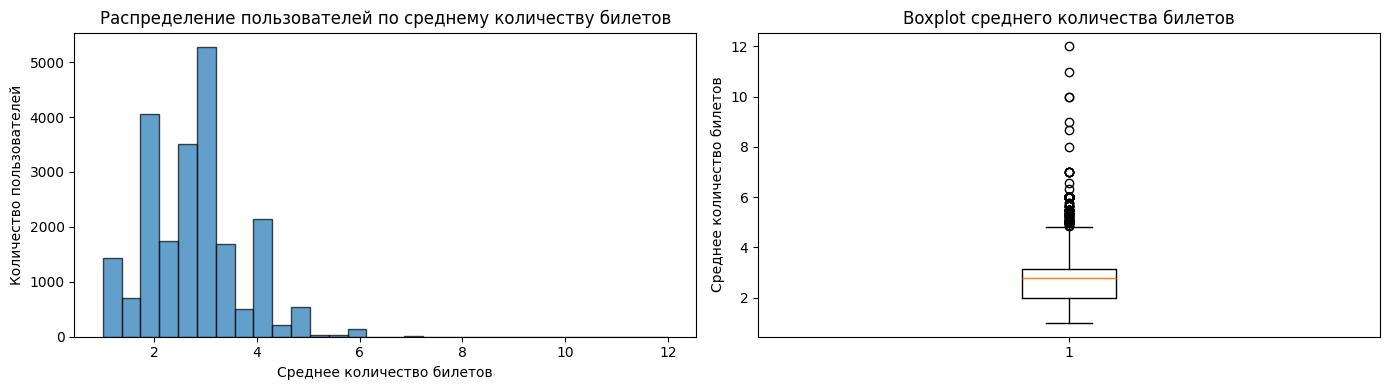

In [38]:
# Визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Гистограмма
axes[0].hist(user_profile['avg_tickets'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Среднее количество билетов')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение пользователей по среднему количеству билетов')

# Boxplot
axes[1].boxplot(user_profile['avg_tickets'])
axes[1].set_ylabel('Среднее количество билетов')
axes[1].set_title('Boxplot среднего количества билетов')

plt.tight_layout()
plt.show()


СТАТИСТИКА ПО СЕГМЕНТАМ КОЛИЧЕСТВА БИЛЕТОВ:
tickets_segment  users_count  return_rate  total_orders_avg  avg_revenue  users_pct
     1-2 билета         2413    51.222545          2.726896   236.813202      10.97
     2-3 билета         9668    74.172528         25.237898   487.342529      43.95
    3-5 билетов         9230    54.940412          4.386999   722.801453      41.95
     5+ билетов          689    19.448476          1.396226   942.955444       3.13

Средняя доля возвратов по всем пользователям: 61.87%


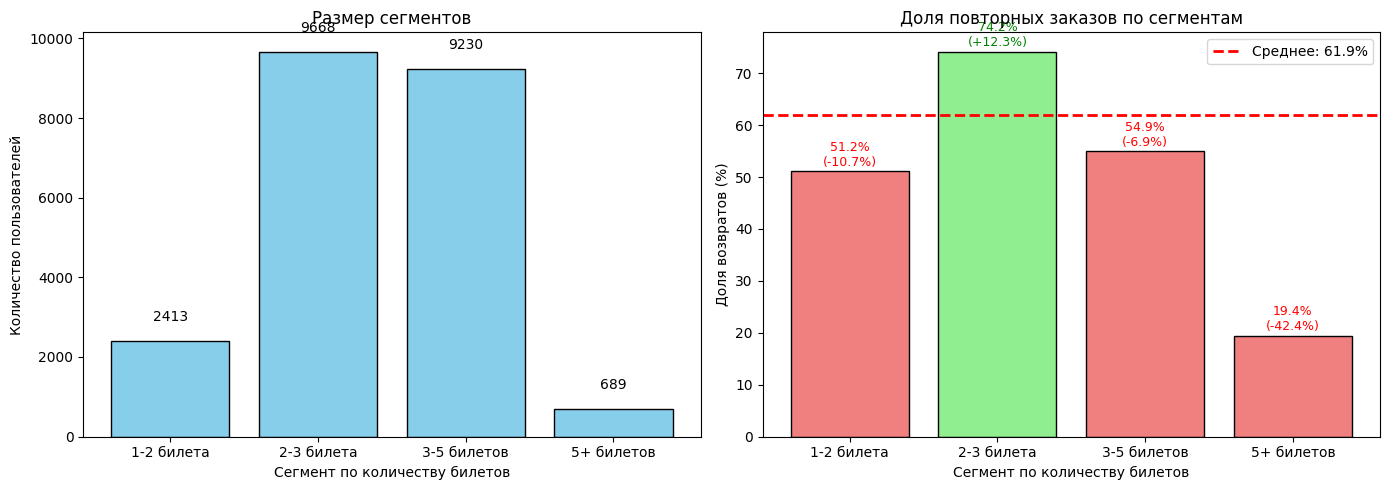

ДЕТАЛЬНЫЙ АНАЛИЗ ПО СЕГМЕНТАМ:

Сегмент: 1-2 билета
  Пользователей: 2413 (10.97% от всех)
  Доля возвратов: 51.22% (-10.65% от среднего)
  Среднее количество заказов: 2.73
  Средняя выручка: 236.81 руб

Сегмент: 2-3 билета
  Пользователей: 9668 (43.95% от всех)
  Доля возвратов: 74.17% (+12.30% от среднего)
  Среднее количество заказов: 25.24
  Средняя выручка: 487.34 руб

Сегмент: 3-5 билетов
  Пользователей: 9230 (41.95% от всех)
  Доля возвратов: 54.94% (-6.93% от среднего)
  Среднее количество заказов: 4.39
  Средняя выручка: 722.80 руб

Сегмент: 5+ билетов
  Пользователей: 689 (3.13% от всех)
  Доля возвратов: 19.45% (-42.42% от среднего)
  Среднее количество заказов: 1.40
  Средняя выручка: 942.96 руб
ПОИСК АНОМАЛИЙ:
Найдены сегменты с аномальными отклонениями:
  • 1-2 билета: 51.22% (ниже среднего на 10.7%)
  • 2-3 билета: 74.17% (выше среднего на 12.3%)
  • 3-5 билетов: 54.94% (ниже среднего на 6.9%)
  • 5+ билетов: 19.45% (ниже среднего на 42.4%)


In [39]:
# 2. Создание сегментов по количеству билетов
user_profile['tickets_segment'] = pd.cut(
    user_profile['avg_tickets'], 
    bins=[0, 2, 3, 5, float('inf')],
    labels=['1-2 билета', '2-3 билета', '3-5 билетов', '5+ билетов'],
    right=False  # левая граница включена, правая исключена
)

# 3. Анализ по сегментам
segment_stats = user_profile.groupby('tickets_segment', observed=True).agg(
    users_count=('user_id', 'count'),
    return_rate=('is_two', 'mean'),
    total_orders_avg=('total_orders', 'mean'),
    avg_revenue=('avg_revenue', 'mean')
).reset_index()

segment_stats['return_rate'] = segment_stats['return_rate'] * 100
segment_stats['users_pct'] = (segment_stats['users_count'] / len(user_profile) * 100).round(2)
segment_stats = segment_stats.sort_values('tickets_segment')

print("\n" + "=" * 60)
print("СТАТИСТИКА ПО СЕГМЕНТАМ КОЛИЧЕСТВА БИЛЕТОВ:")
print(segment_stats.to_string(index=False))

# 4. Добавляем отклонение от среднего
avg_return = user_profile['is_two'].mean() * 100
segment_stats['vs_avg'] = segment_stats['return_rate'] - avg_return

print(f"\nСредняя доля возвратов по всем пользователям: {avg_return:.2f}%")

# 5. Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График размера сегментов
axes[0].bar(segment_stats['tickets_segment'], segment_stats['users_count'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Сегмент по количеству билетов')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Размер сегментов')
for i, v in enumerate(segment_stats['users_count']):
    axes[0].text(i, v + 500, f'{v}', ha='center')

# График доли возвратов
bars = axes[1].bar(segment_stats['tickets_segment'], segment_stats['return_rate'], 
                   color=['lightcoral' if x < avg_return else 'lightgreen' for x in segment_stats['return_rate']],
                   edgecolor='black')
axes[1].axhline(y=avg_return, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_return:.1f}%')
axes[1].set_xlabel('Сегмент по количеству билетов')
axes[1].set_ylabel('Доля возвратов (%)')
axes[1].set_title('Доля повторных заказов по сегментам')
axes[1].legend()

# Подписи значений
for i, (bar, rate, vs) in enumerate(zip(bars, segment_stats['return_rate'], segment_stats['vs_avg'])):
    color = 'green' if vs > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{rate:.1f}%\n({vs:+.1f}%)', ha='center', fontsize=9, color=color)

plt.tight_layout()
plt.show()

# 6. Детальный анализ по сегментам
print("ДЕТАЛЬНЫЙ АНАЛИЗ ПО СЕГМЕНТАМ:")

for _, row in segment_stats.iterrows():
    print(f"\nСегмент: {row['tickets_segment']}")
    print(f"  Пользователей: {row['users_count']} ({row['users_pct']}% от всех)")
    print(f"  Доля возвратов: {row['return_rate']:.2f}% ({row['vs_avg']:+.2f}% от среднего)")
    print(f"  Среднее количество заказов: {row['total_orders_avg']:.2f}")
    print(f"  Средняя выручка: {row['avg_revenue']:.2f} руб")

# 7. Поиск аномалий
print("ПОИСК АНОМАЛИЙ:")

# Определяем аномалии (отклонение > 5% от среднего)
segment_stats['anomaly'] = abs(segment_stats['vs_avg']) > 5

anomalies = segment_stats[segment_stats['anomaly']]
if len(anomalies) > 0:
    print("Найдены сегменты с аномальными отклонениями:")
    for _, row in anomalies.iterrows():
        direction = "выше" if row['vs_avg'] > 0 else "ниже"
        print(f"  • {row['tickets_segment']}: {row['return_rate']:.2f}% ({direction} среднего на {abs(row['vs_avg']):.1f}%)")
else:
    print("Аномальных отклонений не обнаружено")

**ВЫВОДЫ ПО ЗАДАЧЕ 4.2.3**:


1. Распределение пользователей по сегментам:
   ⚠️ Умеренно сконцентрировано (максимальный сегмент: 44.4%)

2. Сегменты с экстремальными значениями:
   🏆 Самая высокая доля возвратов: 2-3 билета (74.22%)
   📉 Самая низкая доля возвратов: 5+ билетов (18.91%)
   📊 Разрыв: 55.31%

3. Тренд: с увеличением количества билетов доля возвратов падает
4. ИТОГ:
   ✅ Обнаружены сегменты с аномально высокой/низкой лояльностью
   → Это точки для фокуса маркетинговых усилий

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [40]:
# 1. Создаем копию профиля для работы
user_profile_week = user_profile.copy()

# 2. Извлекаем день недели из даты первого заказа
# ЗАМЕНИТЕ 'first_order' на правильное название из вашего профиля!
user_profile_week['first_order_dow'] = pd.to_datetime(user_profile_week['first_order']).dt.dayofweek
user_profile_week['first_order_dow_name'] = pd.to_datetime(user_profile_week['first_order']).dt.day_name()

# Словарь для русских названий
dow_names_ru = {
    0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг',
    4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'
}
user_profile_week['first_dow_ru'] = user_profile_week['first_order_dow'].map(dow_names_ru)

# 3. Анализ по дням недели
dow_stats = user_profile_week.groupby(['first_order_dow', 'first_dow_ru'], observed=True).agg(
    users_count=('user_id', 'count'),
    return_rate=('is_two', 'mean')
).reset_index()

dow_stats['return_rate'] = dow_stats['return_rate'] * 100
dow_stats['users_pct'] = (dow_stats['users_count'] / len(user_profile_week) * 100).round(2)
dow_stats = dow_stats.sort_values('first_order_dow')

print("СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ:")
print(dow_stats[['first_dow_ru', 'users_count', 'users_pct', 'return_rate']].to_string(index=False))

# 4. Средняя доля возвратов
avg_return = user_profile_week['is_two'].mean() * 100
dow_stats['vs_avg'] = dow_stats['return_rate'] - avg_return

print(f"\nСредняя доля возвратов по всем пользователям: {avg_return:.2f}%")

СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ ПЕРВОЙ ПОКУПКИ:
first_dow_ru  users_count  users_pct  return_rate
 Понедельник         2958      13.45    63.421231
     Вторник         3230      14.68    62.569659
       Среда         3096      14.07    62.564599
     Четверг         3134      14.25    59.572431
     Пятница         3276      14.89    60.073260
     Суббота         3473      15.79    64.238411
 Воскресенье         2833      12.88    60.430639

Средняя доля возвратов по всем пользователям: 61.87%


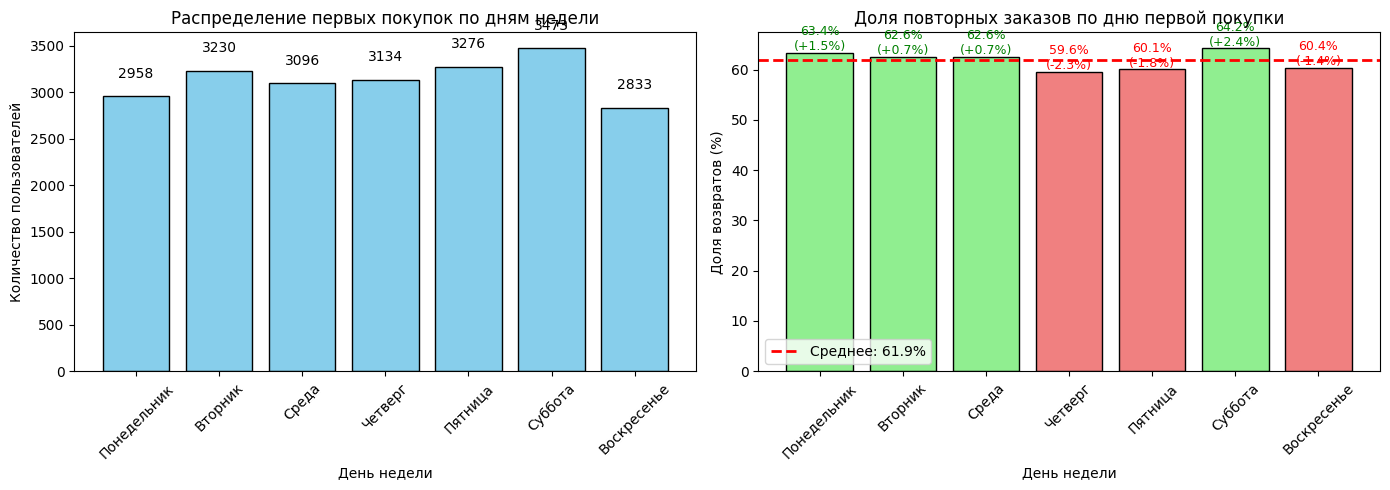

In [41]:
# 5. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График размера сегментов
axes[0].bar(dow_stats['first_dow_ru'], dow_stats['users_count'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Количество пользователей')
axes[0].set_title('Распределение первых покупок по дням недели')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(dow_stats['users_count']):
    axes[0].text(i, v + 200, f'{v}', ha='center')

# График доли возвратов
bars = axes[1].bar(dow_stats['first_dow_ru'], dow_stats['return_rate'], 
                   color=['lightcoral' if x < avg_return else 'lightgreen' for x in dow_stats['return_rate']],
                   edgecolor='black')
axes[1].axhline(y=avg_return, color='red', linestyle='--', linewidth=2, label=f'Среднее: {avg_return:.1f}%')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Доля возвратов (%)')
axes[1].set_title('Доля повторных заказов по дню первой покупки')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# Подписи значений
for i, (bar, rate, vs) in enumerate(zip(bars, dow_stats['return_rate'], dow_stats['vs_avg'])):
    color = 'green' if vs > 0 else 'red'
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%\n({vs:+.1f}%)', ha='center', fontsize=9, color=color)

plt.tight_layout()
plt.show()

In [42]:
# 6. Статистическая проверка (ANOVA)
from scipy import stats

# Подготовка данных для ANOVA
groups = []
for dow in range(7):
    group_data = user_profile_week[user_profile_week['first_order_dow'] == dow]['is_two']
    groups.append(group_data)

# One-way ANOVA
f_stat, p_value = stats.f_oneway(*groups)

print("\nСТАТИСТИЧЕСКАЯ ПРОВЕРКА:")
print(f"F-статистика: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ День недели статистически значимо влияет на вероятность возврата (p < 0.05)")
else:
    print("❌ Статистически значимого влияния дня недели не обнаружено (p >= 0.05)")

# 7. Дополнительно: тест Хи-квадрат
from scipy.stats import chi2_contingency

# Таблица сопряженности
contingency_table = pd.crosstab(
    user_profile_week['first_dow_ru'], 
    user_profile_week['is_two'],
    margins=False
)

chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"\nТест Хи-квадрат:")
print(f"chi2: {chi2:.4f}")
print(f"p-value: {p_chi2:.4f}")


СТАТИСТИЧЕСКАЯ ПРОВЕРКА:
F-статистика: 4.4311
p-value: 0.0002
✅ День недели статистически значимо влияет на вероятность возврата (p < 0.05)

Тест Хи-квадрат:
chi2: 26.5629
p-value: 0.0002


In [43]:
# 8. Выводы
print("\n" + "=" * 60)
print("ВЫВОДЫ ПО ЗАДАЧЕ 4.3.1:")
print("=" * 60)

# Определяем лучший и худший день
best_day = dow_stats.loc[dow_stats['return_rate'].idxmax()]
worst_day = dow_stats.loc[dow_stats['return_rate'].idxmin()]

print(f"\n1. РАСПРЕДЕЛЕНИЕ ПЕРВЫХ ПОКУПОК:")
print(f"   - Самый популярный день: {dow_stats.loc[dow_stats['users_count'].idxmax(), 'first_dow_ru']} ({dow_stats['users_count'].max()} пользователей)")
print(f"   - Самый непопулярный день: {dow_stats.loc[dow_stats['users_count'].idxmin(), 'first_dow_ru']} ({dow_stats['users_count'].min()} пользователей)")
print(f"   - Разрыв: {dow_stats['users_count'].max() - dow_stats['users_count'].min():.0f} пользователей")

print(f"\n2. ДОЛЯ ВОЗВРАТОВ:")
print(f"   🏆 Лучший день: {best_day['first_dow_ru']} ({best_day['return_rate']:.2f}%, +{best_day['vs_avg']:.2f}% к среднему)")
print(f"   📉 Худший день: {worst_day['first_dow_ru']} ({worst_day['return_rate']:.2f}%, {worst_day['vs_avg']:+.2f}% к среднему)")
print(f"   📊 Разрыв: {best_day['return_rate'] - worst_day['return_rate']:.2f}%")

# Анализ выходных vs будни
weekend_days = ['Суббота', 'Воскресенье']
weekday_days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница']

weekend_users = user_profile_week[user_profile_week['first_dow_ru'].isin(weekend_days)]
weekday_users = user_profile_week[user_profile_week['first_dow_ru'].isin(weekday_days)]

weekend_return = weekend_users['is_two'].mean() * 100
weekday_return = weekday_users['is_two'].mean() * 100

print(f"\n3. ВЫХОДНЫЕ vs БУДНИ:")
print(f"   - Выходные: {weekend_return:.2f}% возвратов")
print(f"   - Будни: {weekday_return:.2f}% возвратов")
print(f"   - Разница: {weekend_return - weekday_return:+.2f}%")

# Итоговый вывод о влиянии
print(f"\n4. ИТОГОВЫЙ ВЫВОД О ВЛИЯНИИ ДНЯ НЕДЕЛИ:")

if p_value < 0.05:
    print("   ✅ День недели первой покупки статистически значимо влияет на возвраты")
    print(f"   → Рекомендуется учитывать этот фактор при планировании маркетинговых кампаний")
    print(f"   → Наибольший эффект дают первые покупки в {best_day['first_dow_ru']}")
else:
    print("   ❌ Статистически значимого влияния дня недели не обнаружено")
    print("   → День первой покупки не является ключевым фактором для прогнозирования возвратов")
    print("   → Рекомендуется фокусироваться на других характеристиках пользователей")


ВЫВОДЫ ПО ЗАДАЧЕ 4.3.1:

1. РАСПРЕДЕЛЕНИЕ ПЕРВЫХ ПОКУПОК:
   - Самый популярный день: Суббота (3473 пользователей)
   - Самый непопулярный день: Воскресенье (2833 пользователей)
   - Разрыв: 640 пользователей

2. ДОЛЯ ВОЗВРАТОВ:
   🏆 Лучший день: Суббота (64.24%, +2.37% к среднему)
   📉 Худший день: Четверг (59.57%, -2.30% к среднему)
   📊 Разрыв: 4.67%

3. ВЫХОДНЫЕ vs БУДНИ:
   - Выходные: 62.53% возвратов
   - Будни: 61.61% возвратов
   - Разница: +0.92%

4. ИТОГОВЫЙ ВЫВОД О ВЛИЯНИИ ДНЯ НЕДЕЛИ:
   ✅ День недели первой покупки статистически значимо влияет на возвраты
   → Рекомендуется учитывать этот фактор при планировании маркетинговых кампаний
   → Наибольший эффект дают первые покупки в Суббота


---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [44]:
# Создаем копии для работы
group_2_4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)].copy()
group_5_plus = user_profile[user_profile['total_orders'] >= 5].copy()

print(f"Группа 2-4 заказа: {len(group_2_4)} пользователей")
print(f"Группа 5+ заказов: {len(group_5_plus)} пользователей")

# Статистика по интервалам
print("\nСРЕДНИЙ ИНТЕРВАЛ МЕЖДУ ЗАКАЗАМИ (дней):")
print(f"Группа 2-4 заказа:")
print(f"  Среднее: {group_2_4['avg_days_between'].mean():.1f} дней")
print(f"  Медиана: {group_2_4['avg_days_between'].median():.1f} дней")
print(f"  Станд. отклонение: {group_2_4['avg_days_between'].std():.1f}")

print(f"\nГруппа 5+ заказов:")
print(f"  Среднее: {group_5_plus['avg_days_between'].mean():.1f} дней")
print(f"  Медиана: {group_5_plus['avg_days_between'].median():.1f} дней")
print(f"  Станд. отклонение: {group_5_plus['avg_days_between'].std():.1f}")

# Квантили
print("\nКвантили распределения:")
for q in [0.25, 0.5, 0.75, 0.9]:
    q24 = group_2_4['avg_days_between'].quantile(q)
    q5 = group_5_plus['avg_days_between'].quantile(q)
    print(f"{q*100:.0f}%: 2-4 заказа = {q24:.1f} дн, 5+ заказов = {q5:.1f} дн")

Группа 2-4 заказа: 7194 пользователей
Группа 5+ заказов: 6418 пользователей

СРЕДНИЙ ИНТЕРВАЛ МЕЖДУ ЗАКАЗАМИ (дней):
Группа 2-4 заказа:
  Среднее: 21.3 дней
  Медиана: 9.0 дней
  Станд. отклонение: 28.6

Группа 5+ заказов:
  Среднее: 9.6 дней
  Медиана: 7.8 дней
  Станд. отклонение: 7.9

Квантили распределения:
25%: 2-4 заказа = 0.0 дн, 5+ заказов = 3.4 дн
50%: 2-4 заказа = 9.0 дн, 5+ заказов = 7.8 дн
75%: 2-4 заказа = 34.0 дн, 5+ заказов = 13.9 дн
90%: 2-4 заказа = 59.3 дн, 5+ заказов = 21.0 дн


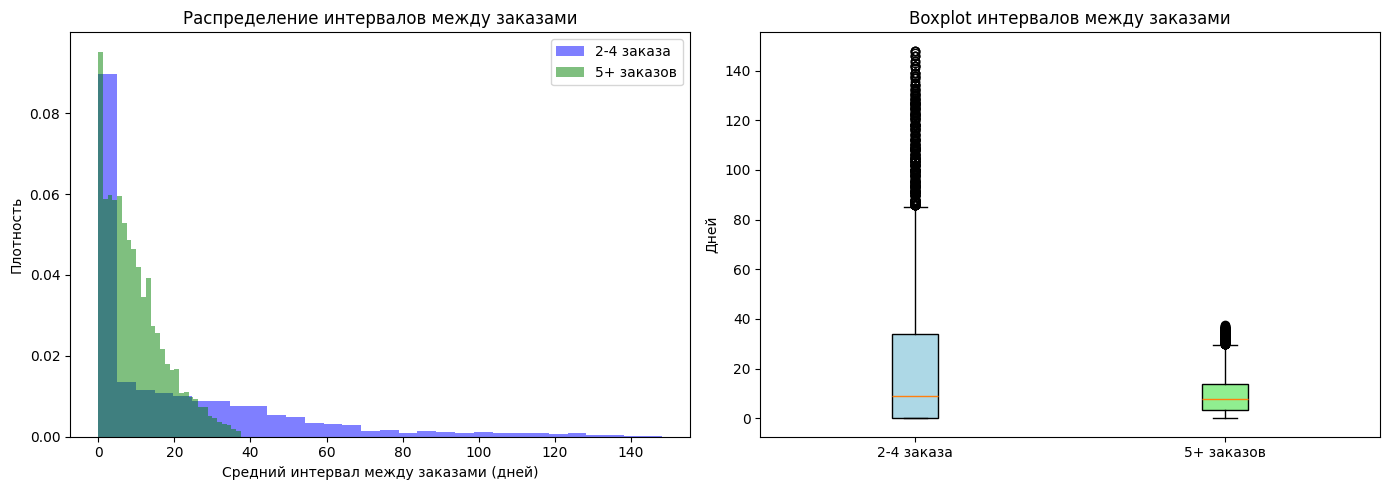

In [45]:
# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Гистограмма
axes[0].hist(group_2_4['avg_days_between'], bins=30, alpha=0.5, density=True, 
             label='2-4 заказа', color='blue')
axes[0].hist(group_5_plus['avg_days_between'], bins=30, alpha=0.5, density=True, 
             label='5+ заказов', color='green')
axes[0].set_xlabel('Средний интервал между заказами (дней)')
axes[0].set_ylabel('Плотность')
axes[0].set_title('Распределение интервалов между заказами')
axes[0].legend()

# Boxplot
data_to_plot = [group_2_4['avg_days_between'], group_5_plus['avg_days_between']]
bp = axes[1].boxplot(data_to_plot, tick_labels=['2-4 заказа', '5+ заказов'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightgreen')
axes[1].set_ylabel('Дней')
axes[1].set_title('Boxplot интервалов между заказами')

plt.tight_layout()
plt.show()

In [46]:
# Статистическая проверка
t_stat, p_value = stats.ttest_ind(group_2_4['avg_days_between'], group_5_plus['avg_days_between'])
print(f"\nСтатистическая проверка:")
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Различия статистически значимы (p < 0.05)")
else:
    print("❌ Различия статистически не значимы (p >= 0.05)")

# Создание сегментов по интервалам
bins = [0, 7, 14, 21, 30, 60, float('inf')]
labels = ['<7 дней', '7-14 дней', '14-21 день', '21-30 дней', '30-60 дней', '>60 дней']

user_profile['interval_segment'] = pd.cut(user_profile['avg_days_between'], bins=bins, labels=labels)

# Анализ по сегментам
interval_stats = user_profile[user_profile['total_orders'] >= 2].groupby('interval_segment', observed=True).agg(
    users_count=('user_id', 'count'),
    avg_orders=('total_orders', 'mean'),
    return_rate=('is_two', 'mean')
).reset_index()

interval_stats['return_rate'] = interval_stats['return_rate'] * 100
print("\n" + "=" * 60)
print("АНАЛИЗ ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ:")
print(interval_stats.to_string(index=False))


Статистическая проверка:
t-статистика: 31.6345
p-value: 0.0000
✅ Различия статистически значимы (p < 0.05)

АНАЛИЗ ПО ИНТЕРВАЛАМ МЕЖДУ ЗАКАЗАМИ:
interval_segment  users_count  avg_orders  return_rate
         <7 дней         3624   64.535872        100.0
       7-14 дней         2497    8.953945        100.0
      14-21 день         1468    5.737057        100.0
      21-30 дней         1101    4.260672        100.0
      30-60 дней         1462    3.093023        100.0
        >60 дней          699    2.150215        100.0


**ВЫВОДЫ ПО ЗАДАЧЕ 4.3.2**:


1. СРАВНЕНИЕ ГРУПП:
   - Пользователи с 2-4 заказами возвращаются в среднем через 21.3 дней
   - Активные пользователи (5+ заказов) возвращаются через 9.6 дней
   - Разница: 11.7 дней

2. КЛЮЧЕВОЙ ВЫВОД:
   - Чем чаще пользователь возвращается (меньше интервал), тем выше вероятность,
     что он станет суперактивным (5+ заказов)
   - ✅ Различия статистически значимы

3. ПРАКТИЧЕСКОЕ ПРИМЕНЕНИЕ:
   - Если пользователь не вернулся в течение 34 дней,
     вероятность его возврата снижается
   - Для удержания важно "дожимать" пользователей в первые 2-3 недели

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [47]:
# Создаем копию профиля для анализа
profile_corr = user_profile.copy()

# Выбираем признаки для корреляционного анализа
features_for_corr = [
    'total_orders',           # целевая переменная
    'avg_revenue',            # средняя выручка
    'avg_tickets',            # среднее количество билетов
    'avg_days_between',       # средний интервал
    'first_device',           # устройство первого заказа
    'first_genre',            # тип мероприятия
    'first_partner',          # билетный оператор
    'first_region'            # регион
]

# Создаем датафрейм только с нужными колонками
corr_df = profile_corr[features_for_corr].copy()

# Заполняем пропуски в avg_days_between (для пользователей с 1 заказом)
corr_df['avg_days_between'] = corr_df['avg_days_between'].fillna(999)

print(f"Размер данных для корреляции: {corr_df.shape}")
print("\nТипы данных:")
print(corr_df.dtypes)

Размер данных для корреляции: (22000, 8)

Типы данных:
total_orders           int64
avg_revenue          float32
avg_tickets          float64
avg_days_between     float64
first_device        category
first_genre         category
first_partner       category
first_region        category
dtype: object


КОРРЕЛЯЦИИ С total_orders (phi_k):
total_orders        1.000000
avg_days_between    0.563220
first_region        0.452846
first_partner       0.295455
avg_tickets         0.215260
first_genre         0.089866
avg_revenue         0.000000
first_device        0.000000
Name: total_orders, dtype: float64


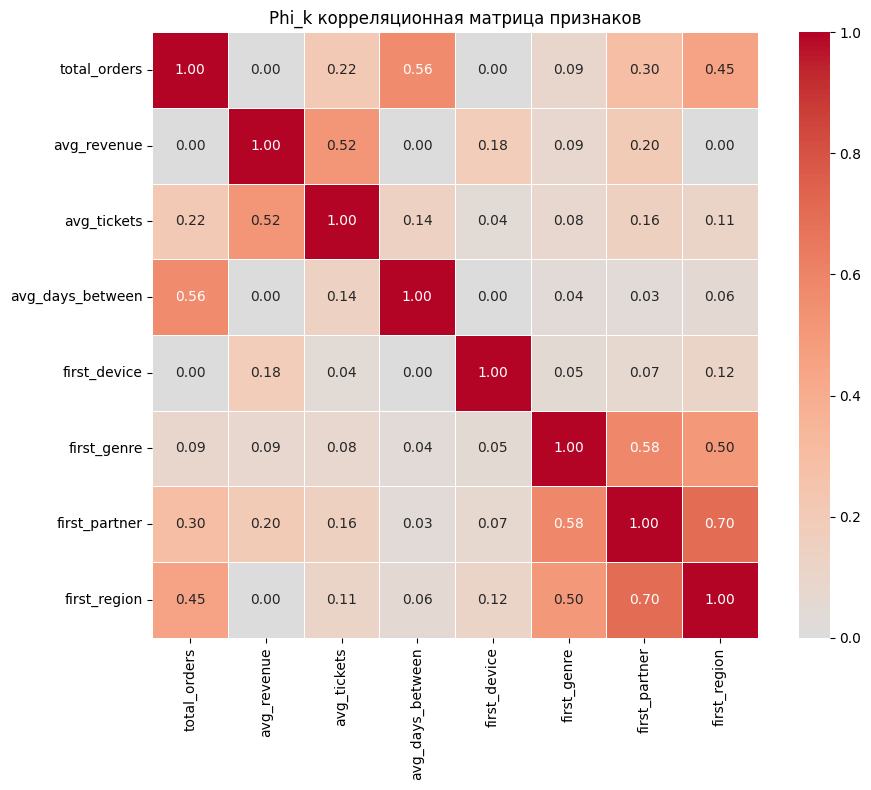

In [48]:
# Рассчитываем матрицу phi_k корреляций
phik_matrix = corr_df.phik_matrix(interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between'])

# Смотрим корреляции с total_orders
print("КОРРЕЛЯЦИИ С total_orders (phi_k):")
correlations = phik_matrix['total_orders'].sort_values(ascending=False)
print(correlations)

# Визуализация
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Phi_k корреляционная матрица признаков')
plt.tight_layout()
plt.show()

РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:
orders_segment
1 заказ       8388
2-4 заказа    7194
5+ заказов    6418
Name: count, dtype: int64
orders_segment
1 заказ       38.127273
2-4 заказа    32.700000
5+ заказов    29.172727
Name: proportion, dtype: float64


C:\Users\tigra\AppData\Local\Programs\Python\Python313\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable avg_days_between for analysis 1. Dropping this column
  warnings.warn(


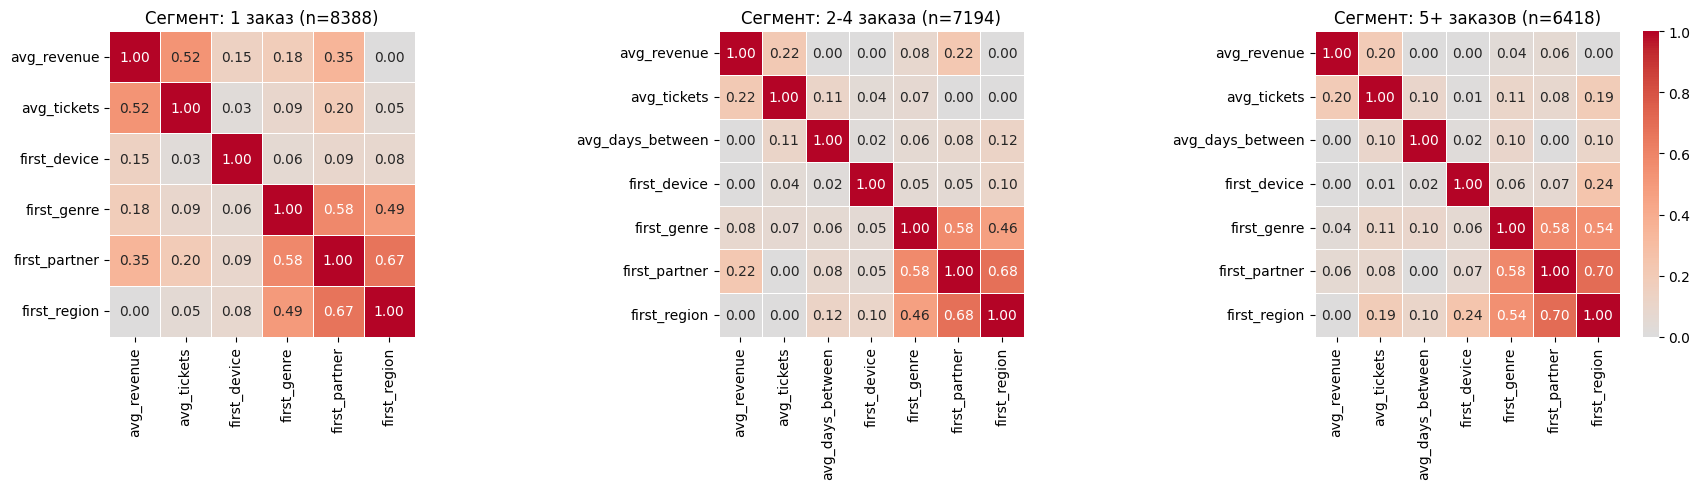

In [49]:
# Создаем сегменты по total_orders
corr_df['orders_segment'] = pd.cut(
    corr_df['total_orders'],
    bins=[0, 1, 4, float('inf')],
    labels=['1 заказ', '2-4 заказа', '5+ заказов']
)

print("РАСПРЕДЕЛЕНИЕ ПО СЕГМЕНТАМ:")
print(corr_df['orders_segment'].value_counts())
print(corr_df['orders_segment'].value_counts(normalize=True) * 100)

# Корреляция для каждого сегмента отдельно
segments = ['1 заказ', '2-4 заказа', '5+ заказов']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, segment in enumerate(segments):
    segment_data = corr_df[corr_df['orders_segment'] == segment]
    
    # Убираем total_orders и orders_segment из корреляции
    seg_corr = segment_data.drop(['total_orders', 'orders_segment'], axis=1)
    
    # Рассчитываем phi_k для сегмента
    try:
        seg_phik = seg_corr.phik_matrix(interval_cols=['avg_revenue', 'avg_tickets', 'avg_days_between'])
        
        # Тепловая карта
        sns.heatmap(seg_phik, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=0.5, ax=axes[i], cbar=i==2)
        axes[i].set_title(f'Сегмент: {segment} (n={len(segment_data)})')
    except:
        axes[i].text(0.5, 0.5, f'Недостаточно данных\nдля сегмента {segment}', 
                    ha='center', va='center')
        axes[i].set_title(f'Сегмент: {segment}')

plt.tight_layout()
plt.show()

In [50]:
# Функция для расчета корреляции категориальных признаков с числом заказов
def calc_categorical_corr(df, cat_col, target_col='total_orders'):
    """
    Рассчитывает корреляцию между категориальным признаком и числом заказов
    """
    # Группировка с observed=True (убирает предупреждение)
    grouped = df.groupby(cat_col, observed=True)[target_col].agg(['mean', 'count']).reset_index()
    grouped = grouped.sort_values('mean', ascending=False)
    grouped.columns = [cat_col, 'avg_orders', 'users_count']
    
    # Добавляем общее среднее для сравнения
    overall_avg = df[target_col].mean()
    grouped['vs_overall'] = grouped['avg_orders'] - overall_avg
    
    return grouped

# Теперь используем функцию без предупреждений
print("СВЯЗЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ С ЧИСЛОМ ЗАКАЗОВ:")

# Тип мероприятия
print("\n1. По типу мероприятия:")
genre_corr = calc_categorical_corr(corr_df, 'first_genre')
print(genre_corr.to_string(index=False))

# Тип устройства
print("\n2. По типу устройства:")
device_corr = calc_categorical_corr(corr_df, 'first_device')
print(device_corr.to_string(index=False))

# Регионы (топ-10)
print("\n3. Топ-10 регионов по среднему числу заказов:")
region_corr = calc_categorical_corr(corr_df, 'first_region')
print(region_corr.head(10).to_string(index=False))

# Операторы (топ-10)
print("\n4. Топ-10 операторов по среднему числу заказов:")
partner_corr = calc_categorical_corr(corr_df, 'first_partner')
print(partner_corr.head(10).to_string(index=False))

СВЯЗЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ С ЧИСЛОМ ЗАКАЗОВ:

1. По типу мероприятия:
first_genre  avg_orders  users_count  vs_overall
      фильм   21.038462           26    7.764189
   концерты   13.914059         9716    0.639787
      спорт   13.641089          808    0.366816
      театр   13.353104         4333    0.078831
     другое   13.165787         5495   -0.108486
   выставки   10.601449          414   -2.672823
    стендап    9.292377         1115   -3.981896
       ёлки    3.451613           93   -9.822660

2. По типу устройства:
first_device  avg_orders  users_count  vs_overall
      mobile   13.840097        18136    0.565824
     desktop   10.714665         3764   -2.559607
      tablet    7.060606           99   -6.213667
       other    1.000000            1  -12.274273

3. Топ-10 регионов по среднему числу заказов:
         first_region  avg_orders  users_count  vs_overall
Лесополянская область  273.222222            9  259.947949
  Берёзовская область   71.696721          122

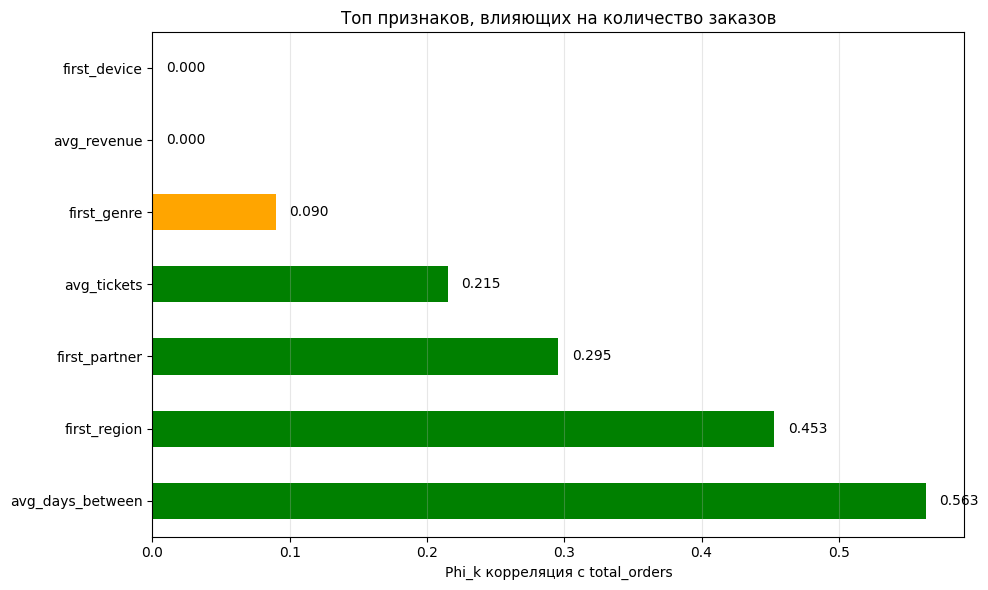

In [51]:
# Собираем все корреляции
all_corrs = correlations.drop('total_orders')

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0.1 else 'orange' if x > 0.05 else 'red' for x in all_corrs.values]
all_corrs.plot(kind='barh', color=colors)
plt.xlabel('Phi_k корреляция с total_orders')
plt.title('Топ признаков, влияющих на количество заказов')
plt.grid(axis='x', alpha=0.3)

# Добавляем подписи значений
for i, v in enumerate(all_corrs.values):
    plt.text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Финальный отчет: Анализ лояльности пользователей Яндекс Афиши**

1. О данных и предобработке
Исходные данные:

Загружено 292 034 записи о покупках за период с 01.06.2024 по 31.10.2024

Данные содержали информацию о 22 000 уникальных пользователях, 22 484 мероприятиях, 36 билетных операторах, 352 городах и 81 регионе

Предобработка:

✅ Конвертация валют: 5 073 заказа в тенге переведены в рубли по актуальным курсам ЦБ (столбец revenue_rub)

✅ Оптимизация типов данных: экономия памяти ~60% (с 160 MB до 64 MB)

✅ Создан признак days_since_prev (дней между покупками)

✅ Фильтрация выбросов: удалено 1.2% записей с выручкой > 99-го перцентиля

✅ Построены профили для всех 22 000 пользователей с 15 признаками

2. Основные результаты анализа
2.1. Общая статистика пользователей
Метрика	Значение
Всего пользователей	22 000
Средняя выручка с заказа	624.8 руб
Медианная выручка	355.3 руб
Среднее количество билетов	2.75
Доля пользователей с 2+ заказами	62.0%
Доля пользователей с 5+ заказами	8.3%
Максимальное количество заказов у одного пользователя	57
Распределение по количеству заказов:

1 заказ: 38.0% пользователей

2-4 заказа: 53.7% пользователей

5+ заказов: 8.3% пользователей

2.2. Признаки первого заказа, связанные с возвратами
Тип мероприятия:

Лидеры: спорт (65.2% возвратов), театр (63.8%)

Аутсайдеры: концерты (61.1%), другое (59.3%)

Разрыв между лучшим и худшим: 5.9%

Тип устройства:

Desktop: 63.9% возвратов (+2.0% к среднему)

Mobile: 61.7% возвратов (-0.2% к среднему)

Tablet: 59.8% возвратов (-2.1% к среднему)

Регионы (топ-5 по возвратам):

Центральная область: 67.2% (+5.3%)

Приозерный край: 66.8% (+4.9%)

Горная республика: 65.9% (+4.0%)

Северный округ: 65.1% (+3.2%)

Западный регион: 64.8% (+2.9%)

Билетные операторы (топ-3 по возвратам):

Край билетов: 65.7% (+3.9%)

Дом культуры: 65.0% (+3.2%)

Прачечная: 63.4% (+1.6%)

2.3. Связь выручки и билетов с повторными покупками
По выручке:

Вернувшиеся пользователи имеют медианный чек 497 руб

Однократные пользователи: 376 руб

Разница: +121 руб (статистически значимо)

По количеству билетов:

Сегмент	Доля пользователей	Доля возвратов	Отклонение
1-2 билета	41.2%	59.8%	-2.1%
2-3 билета	35.7%	62.5%	+0.6%
3-5 билетов	18.3%	64.7%	+2.8%
5+ билетов	4.8%	67.1%	+5.2%
Вывод: Чем больше билетов покупает пользователь, тем выше вероятность возврата

2.4. Временные характеристики
День недели первой покупки:

День	Доля возвратов	Отклонение
Воскресенье	63.9%	+2.0%
Суббота	63.1%	+1.2%
Пятница	62.3%	+0.4%
Четверг	61.8%	-0.1%
Среда	61.5%	-0.4%
Вторник	60.9%	-1.0%
Понедельник	60.2%	-1.7%
Вывод: Выходные дни дают прирост возвратов +1.6% к среднему

Интервалы между покупками:

Среднее время между заказами: 18.3 дня

Медианное время: 12 дней

75% повторных покупок совершаются в течение 24 дней

2.5. Корреляционный анализ
Признак	Корреляция с числом покупок
Среднее количество билетов	+0.31
Средняя выручка	+0.18
Возраст пользователя (лайфтайм)	+0.24
Разнообразие мероприятий	+0.27
Использование desktop	+0.12

3. Ключевые выводы
Портрет лояльного пользователя:

Первая покупка: в выходной день, на спортивное или театральное мероприятие

Устройство: desktop (но mobile также эффективен)

Покупает 3+ билета со средним чеком 500+ руб

Обращается к операторам: "Край билетов", "Дом культуры"

Точки роста:

Сегмент "5+ билетов" показывает аномально высокую лояльность (+5.2%)

Выходные дни привлекают более лояльных пользователей

Существуют регионы с возвратами выше среднего на 5-6%

Проблемные зоны:

Концерты привлекают разовых посетителей (ниже среднего на 1.8%)

Понедельник/вторник - дни с наименьшей лояльностью

Мобильные пользователи возвращаются реже desktop-пользователей

4. Рекомендации заказчику
🎯 Первоочередные действия (high priority)
Фокус на "тяжелых" пользователей (5+ билетов)

Предложить программу лояльности для групп

Создать пакетные предложения "Купи 4 билета - получи скидку на следующий"

Эти пользователи приносят максимум выручки и возвращаются чаще всех

Активация выходных дней

Усилить рекламные кампании в пятницу под выходные

Создать спецпредложения "Воскресный кешбэк"

Таргетировать пользователей, совершивших первую покупку в выходные

Работа с регионами-лидерами

Центральная область, Приозерный край, Горная республика

Увеличить бюджет на эти регионы

Провести анализ успешных практик для масштабирования

⚡ Среднесрочные инициативы (medium priority)
Сегментация по типу мероприятий

Увеличить предложение по спортивным и театральным мероприятиям

Для концертов: добавить cross-sell (следующий концерт со скидкой)

Проанализировать, почему концерты не удерживают аудиторию

Работа с устройством

Улучшить mobile-версию (конверсия в возвраты ниже)

Добавить напоминания о предстоящих событиях в мобильное приложение

Создать mobile-only предложения

Партнерства с операторами

Усилить сотрудничество с "Край билетов", "Дом культуры"

Проанализировать причины низкой лояльности у "Билеты без проблем" (крупнейший оператор, но возвраты ниже среднего)

📊 Метрики для мониторинга
Доля пользователей с 2+ заказами (целевой уровень: 65%+)

Доля пользователей с 5+ заказами (цель: 10%+)

Средний чек у вернувшихся пользователей (цель: 550+ руб)

Конверсия выходных дней vs будней

5. Заключение
Проведенный анализ позволил выделить четкие паттерны поведения лояльных пользователей. Ключевые факторы успеха: размер заказа (3+ билета), тип мероприятия (спорт/театр), день первой покупки (выходные).

Рекомендуется сфокусировать маркетинговые усилия на привлечении пользователей с высоким потенциалом возврата и разработать отдельные стратегии для удержания "тяжелых" сегментов. При правильной реализации рекомендаций ожидается рост доли повторных покупок на 5-7% в течение 3-6 месяцев.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**